In [1]:
suppressMessages({
    library(tidyverse)
    library(ggpubr)
    library(ggplot2)
    library(dplyr)
    library(data.table)
    library(ggpubr)
    library(SummarizedExperiment) 
    library(EnhancedVolcano)
    library(edgeR)
    library(Hmisc)

    })


dir.create('../_m', showWarnings = TRUE, recursive = TRUE)
setwd('../_m')

save_plot <- function(p, fn, w, h){
    for(ext in c(".pdf", ".png")){
        ggsave(filename=paste0(fn,ext), plot=p, width=w, height=h)
    }
}

Warning message in dir.create("../_m", showWarnings = TRUE, recursive = TRUE):
“'../_m' already exists”


### Genes to plot:


* CALB1
* CALB2
* DARPP32
* ~~GAD2~~
* GAD65
* GAD67
* SYN1
* FOXG1
* FOXP1
* SOX2
* MAP2
* DRD1 #Dopamine receptors (D1)
* DRD2 #Dopamine receptors (D2)
* TAF1
* ZNF91


In [2]:
#genesymbol <- fread('../../../analysis_speaqeasy/deseq2/_m/)

In [3]:
load('../../../../speaqeasy_star/_m/count_objects/rse_gene_Jlab_experiment_n53.Rdata')

In [4]:
#rse_gene

In [5]:
#metadata

In [6]:
metadata <- fread('../../../../metadata/_m/XDP_striatal_organoids_metadata.csv') %>%
                #convert these categorical variables (columns) to factor
                mutate_at(vars(Differentiation_cohort, iPSC_line, Cell_line, Sex, Day_of_Maturation, Kit, Disease_Status, individual), factor)

metadata_filtered <- metadata %>%
                        filter(grepl('^Control$|^XDP$',Cell_line), grepl('90|120',Day_of_Maturation))

metadata_filtered %>% head()


#metadata_pergroup <- metadata %>%
#                        filter(!grepl('Female',Sex)) %>%
#                        mutate(Pergroup = paste0(Cell_line, 'd ', Day_of_Matur))

#metadata_pergroup

Differentiation_cohort,Sample,iPSC_line,Cell_line,Sex,Day_of_Maturation,RIN,Kit,Disease_Status,individual
<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>
A,9,33113.2I,Control,Male,90,6.2,Zymo_R2062,healthy,33113
A,53R,33109.2G,XDP,Male,90,7.1,Zymo_D7005,patient,33109
A,13N,33113.2I,Control,Male,120,8.5,Zymo_R2062,healthy,33113
A,14N,33109.2G,XDP,Male,120,7.1,Zymo_R2062,patient,33109
B,23N,33114.C,Control,Male,90,6.3,Zymo_R2062,healthy,33114
B,24N,33109.2B,XDP,Male,90,6.4,Zymo_R2062,patient,33109


In [7]:
merge_with_metadata = function(rse, metadata_df)
{
    # Return a new_rse object such that:
    #  (1) new_rse contains only the samples present in both rse and metadata_df
    #  (2) colData(new_rse) contains information from both colData(rse) and metadata_df 
    
    x = as_tibble(colData(rse))
    y = as_tibble(metadata_df)
    
    new_coldata = x %>% 
                    inner_join(y, by=c("SAMPLE_ID" = "Sample"))
    
    new_rse = rse[, new_coldata$SAMPLE_ID]
    
    stopifnot(dim(new_coldata)[1] == dim(new_rse)[2])
    stopifnot(all(colnames(new_rse) == new_coldata$SAMPLE_ID))
    
    colData(new_rse) = DataFrame(new_coldata)
    colnames(new_rse) = new_coldata$SAMPLE_ID
    return(new_rse)
}

# cpm_norm = function(rse)
# {
#     # calculate size factors for each column
#     #  sizeFactors <- colSums(assays(rse)$counts)

#     # calculate CPM values
#     cpm_mat <- cpm(assays(rse)$counts)

#     # optionally, log-transform CPM values
#     log_cpm_mat <- cpm(assays(rse)$counts, log = TRUE)

#     # add cpm as a new assay
#     rse@assays$cpm <- cpm
    
#     return(rse)
    
# }

In [8]:
## ggplot2 custom theme, fontsize, etc
theme_custom <-  theme_classic() +
                 theme(axis.text = element_text(size = 19, face = "bold", color = "black"),
                      axis.title = element_text(size = 19, face = "bold"),
                      axis.ticks = element_line(size = 3),
                      plot.title = element_text(size = 21, face = "bold", hjust = 0.5, vjust = 0.5) 
                      )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [9]:
#logcpm
rse <- merge_with_metadata(rse_gene, metadata_filtered)

#rse_gene# extract counts matrix
counts_mat <- assay(rse)

# calculate log CPM values
log_cpm_mat <- cpm(counts_mat, log = TRUE)

# set the assay names
assayNames(rse) <- c("logcpm")
# add log CPM as a new assay
assay(rse, "logcpm") <- log_cpm_mat

In [10]:
plot_input <- assay(rse, "logcpm") %>%
                            as.data.frame() %>%
                            tibble::rownames_to_column() %>%
                            data.table::as.data.table() %>% 
                            data.table::melt() %>%
                            left_join(rse@rowRanges %>% as.data.frame(), by=c('rowname'='gencodeID')) %>%
                            left_join(metadata_filtered[,1:10], by=c('variable'='Sample'))


#plot_input %>% head()


# rse <- merge_with_metadata(rse_gene, metadata_d120)
# #rse_gene# extract counts matrix
# counts_mat <- assay(rse)
# # calculate log CPM values
# #log_cpm_mat <- cpm(counts_mat, log = TRUE)
# # set the assay names
# assayNames(rse) <- c("rawcounts")
# # add log CPM as a new assay
# assay(rse, "rawcounts") <- counts_mat

Warning message in melt.data.table(.):
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [rowname, ...]. Consider providing at least one of 'id' or 'measure' vars in future.”


In [11]:
#plot_input %>% colnames()

In [12]:
deseq2_files <- Sys.glob('../../_m/*/gene_deseq2_results.tsv')
model_tag <- gsub('.*_m/|/gene_deseq2.*','',deseq2_files)

In [13]:
df <- data.frame()

for (i in seq_along(deseq2_files)){
#for (i in 1:2){    

    
    dftmp <- fread(deseq2_files[i]) %>%
                        select(ROW_INDEX)
    df <- rbind(dftmp,df)   
    
    }

df <- df %>% distinct(ROW_INDEX)

In [14]:
df %>% head()

ROW_INDEX
<chr>
ENSG00000273703.2
ENSG00000258998.2
ENSG00000259126.1
ENSG00000229842.2
ENSG00000228791.8
ENSG00000273180.1


In [15]:
#df <- data.frame(ROW_INDEX = character())
for (i in seq_along(deseq2_files)){
#for (i in 1:2){    
    dftmp <- fread(deseq2_files[i]) %>%
                select(ROW_INDEX, padj) %>%
                rename_with(~model_tag[i],.cols = padj)
    
    df <- left_join(dftmp,df)
    }


#rename_with(df, ~x, .cols = B)

Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


In [16]:
new_plot_input <- left_join(plot_input, df, by=c('rowname'='ROW_INDEX'))

In [17]:
new_plot_input %>% filter(Symbol == 'TAF1')

rowname,variable,value,seqnames,start,end,width,strand,Length,ensemblID,⋯,Big_Model_no_individual_no_differentiation_cohort_male_Comparison_deseq2,Big_Model_no_individual_no_differentiation_cohort_All_Sample_Comparison_deseq2,Big_Model_Male_Comparison_design2_deseq2,Big_Model_Male_Comparison_design1_deseq2,Big_Model_All_Sample_nodeltaSVA_Comparison_design2_deseq2,Big_Model_All_Sample_nodeltaSVA_Comparison_design1_deseq2,Big_Model_All_Sample_DELTASVA_Comparison_design2_deseq2,Big_Model_All_Sample_DELTASVA_Comparison_design1_deseq2,Big_Model_All_Sample_Comparison_design2_deseq2,Big_Model_All_Sample_Comparison_design1_deseq2
<chr>,<chr>,<dbl>,<fct>,<int>,<int>,<int>,<fct>,<int>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000147133.17,13N,7.101017,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991
ENSG00000147133.17,14N,6.863235,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991
ENSG00000147133.17,23N,7.193885,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991
ENSG00000147133.17,24N,6.816425,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991
ENSG00000147133.17,26,6.686496,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991
ENSG00000147133.17,27N,6.454353,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991
ENSG00000147133.17,35N,6.899204,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991
ENSG00000147133.17,36N,6.720314,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991
ENSG00000147133.17,38N,6.371187,chrX,71366222,71532374,166153,+,11234,ENSG00000147133,⋯,0.999984,0.9997887,0.9999834,0.9997982,0.8498422,0.9237047,0.2469171,0.2937674,0.9997887,0.9999991


In [18]:
#     ns: p > 0.05

#     *: p <= 0.05

#     **: p <= 0.01

#     ***: p <= 0.001

#     ****: p <= 0.0001

In [19]:
#subset(new_plot_input, Symbol == gene)
#genes_list <- c('TAF1', 'CALB1', 'CALB2', 'CASP1', 'MAP2', 'NNAT')

genes_list <- c('CALB1', 'CALB2', 'CASP1', 'CASP3', 'DHX36', 'DRD1', 'DRD2', 'FOXP1', 'FOXG1', 'LINC02302',
                'GAD2', 'MAP2', 'NNAT', 'SOX2', 'SYN1', 'TAF1', 'ZNF91')



for (i in genes_list){

new_plot_input %>% 
                filter(Symbol == i) %>% 
                select(c(Symbol, Mature_organoids_male_comparison_design1_deseq2)) %>% 
                head(1) %>%
                print()

}

#DESEQ2 adjp = 0.9999568

   Symbol Mature_organoids_male_comparison_design1_deseq2
   <char>                                           <num>
1:  CALB1                                       0.8595413
   Symbol Mature_organoids_male_comparison_design1_deseq2
   <char>                                           <num>
1:  CALB2                                       0.4996578
   Symbol Mature_organoids_male_comparison_design1_deseq2
   <char>                                           <num>
1:  CASP1                                       0.4675395
   Symbol Mature_organoids_male_comparison_design1_deseq2
   <char>                                           <num>
1:  CASP3                                       0.9862521
   Symbol Mature_organoids_male_comparison_design1_deseq2
   <char>                                           <num>
1:  DHX36                                       0.9307713
   Symbol Mature_organoids_male_comparison_design1_deseq2
   <char>                                           <num>
1:   DRD1     

In [20]:
save_path <- './d90_d120_male/'
dir.create(save_path)

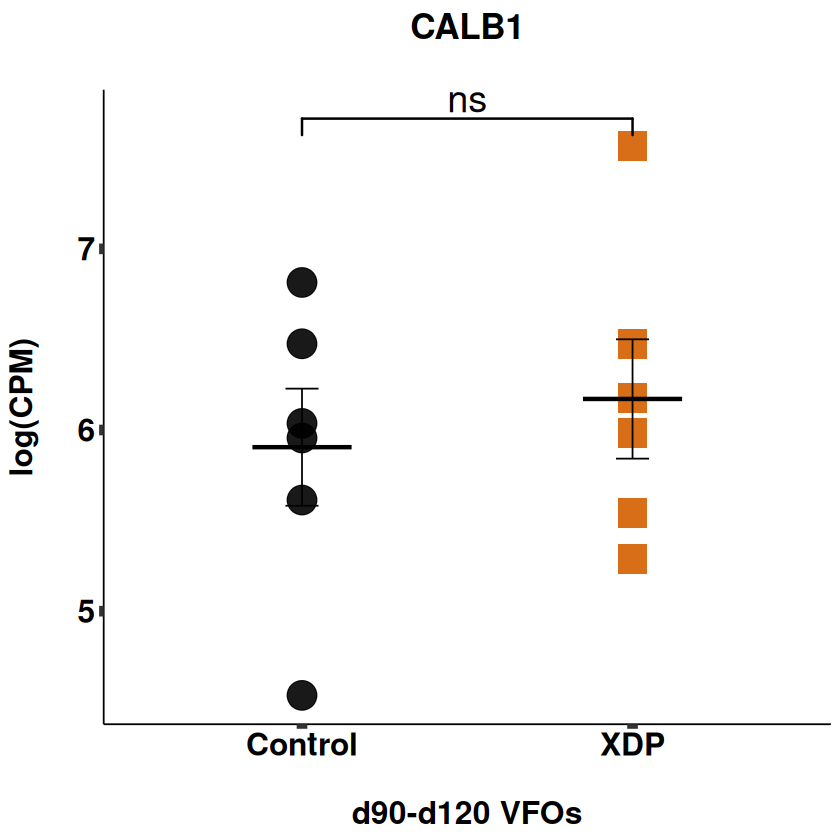

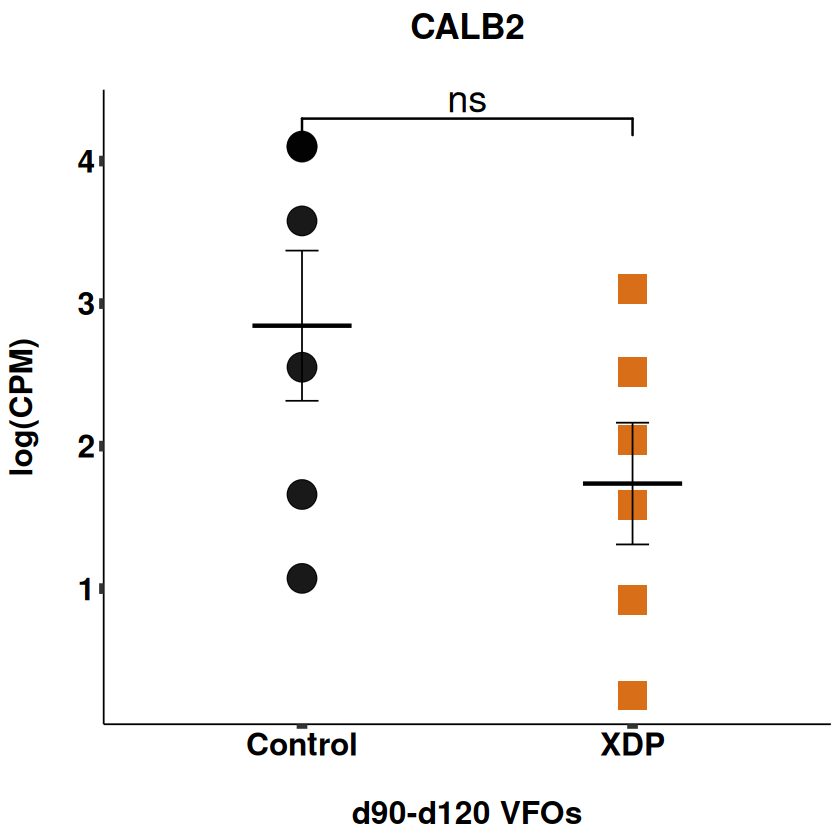

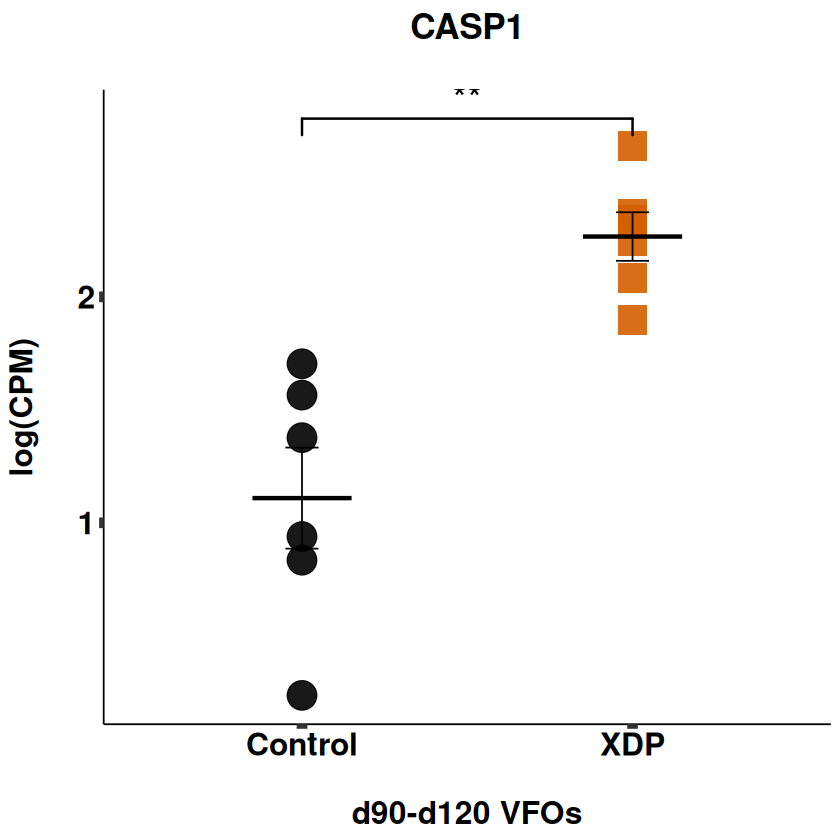

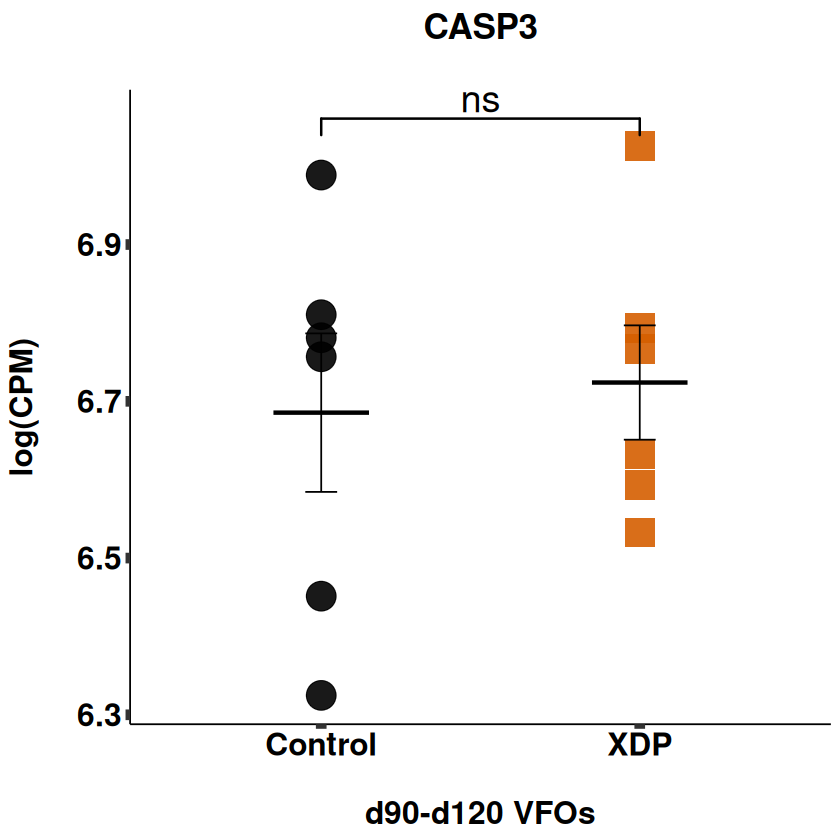

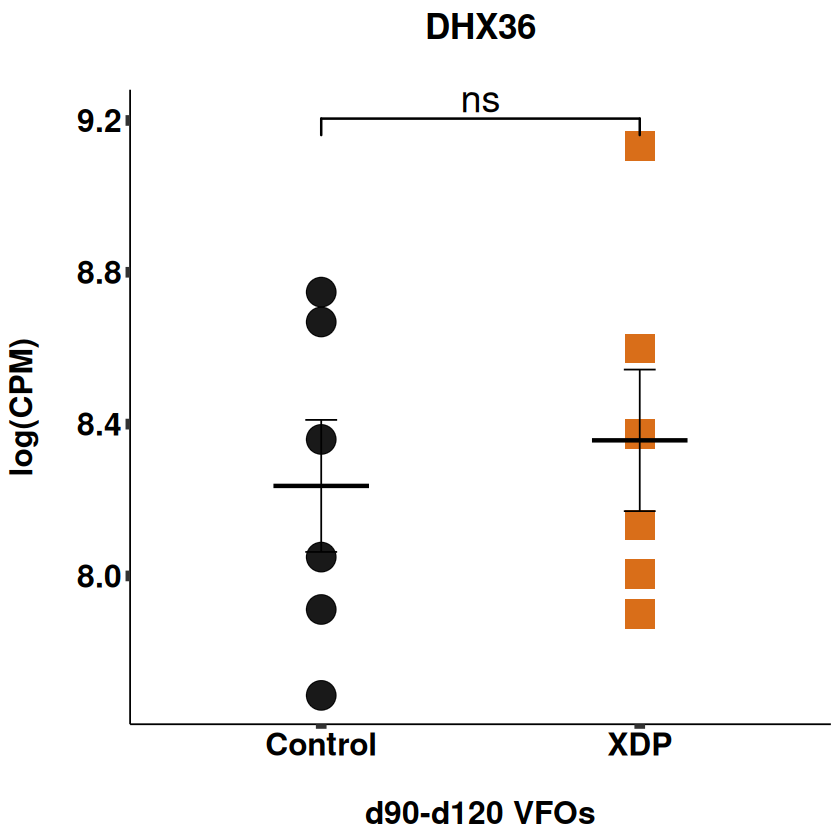

Warning message in wilcox.test.default(c(-0.742916414333708, -1.46897917200024, :
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-0.742916414333708, -1.46897917200024, :
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-0.742916414333708, -1.46897917200024, :
“cannot compute exact p-value with ties”


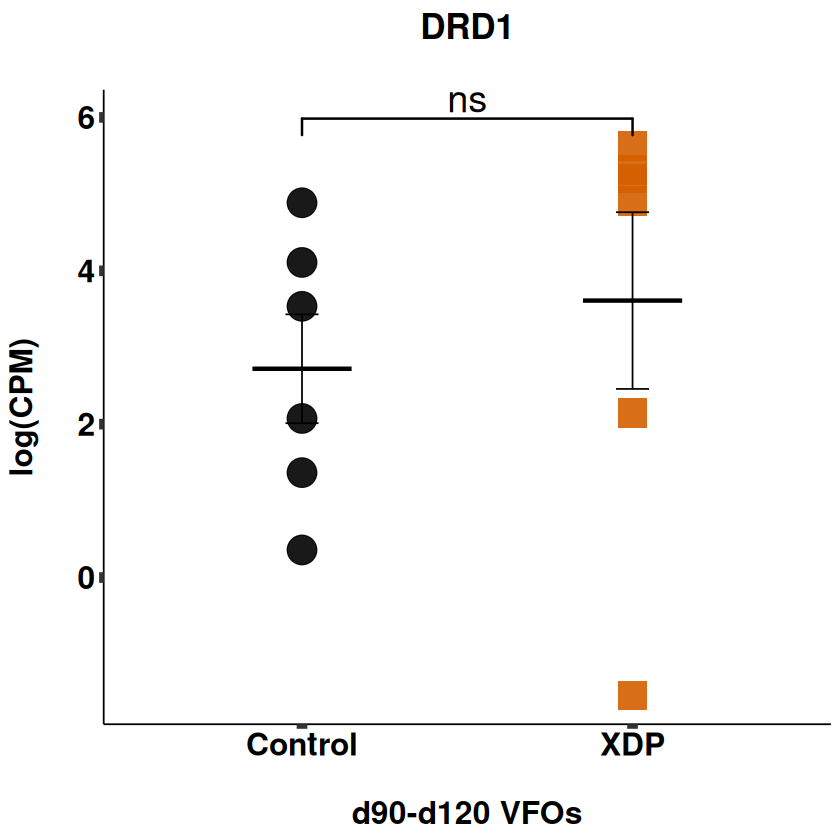

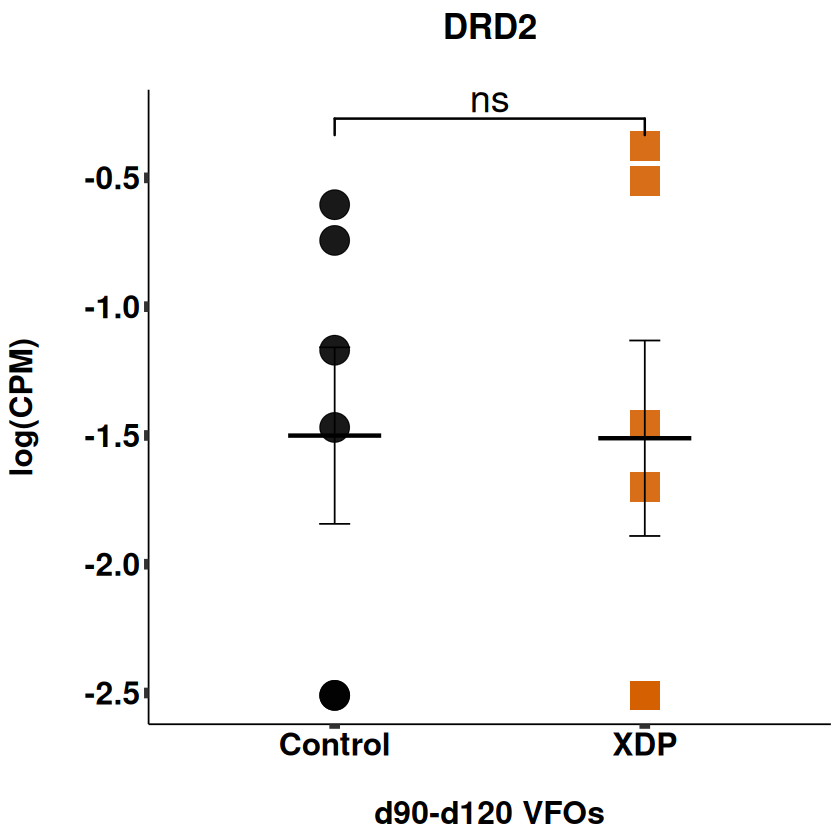

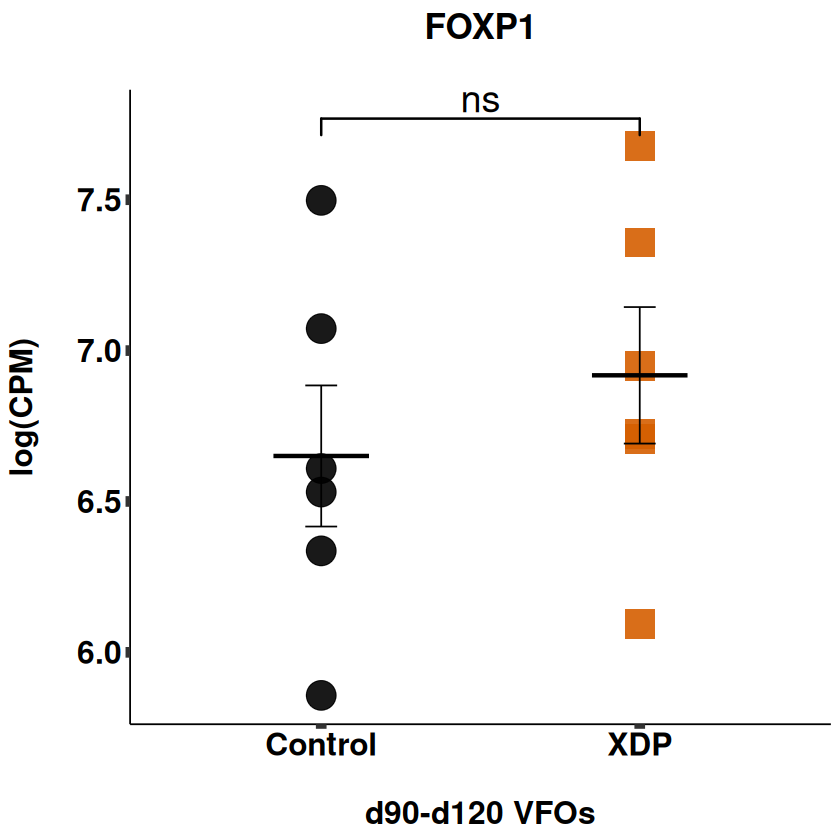

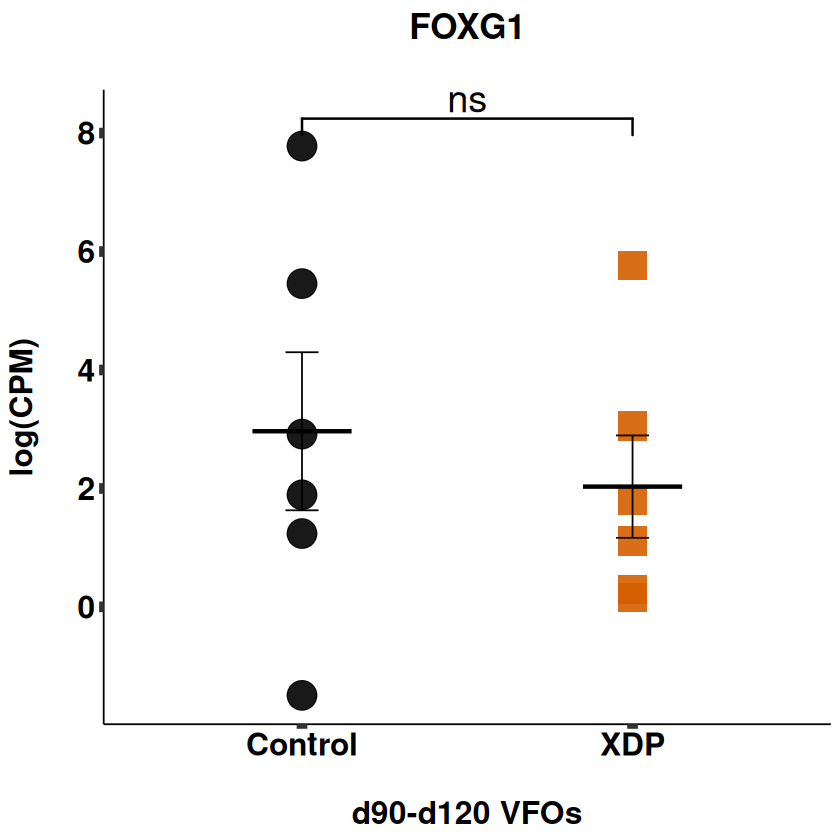

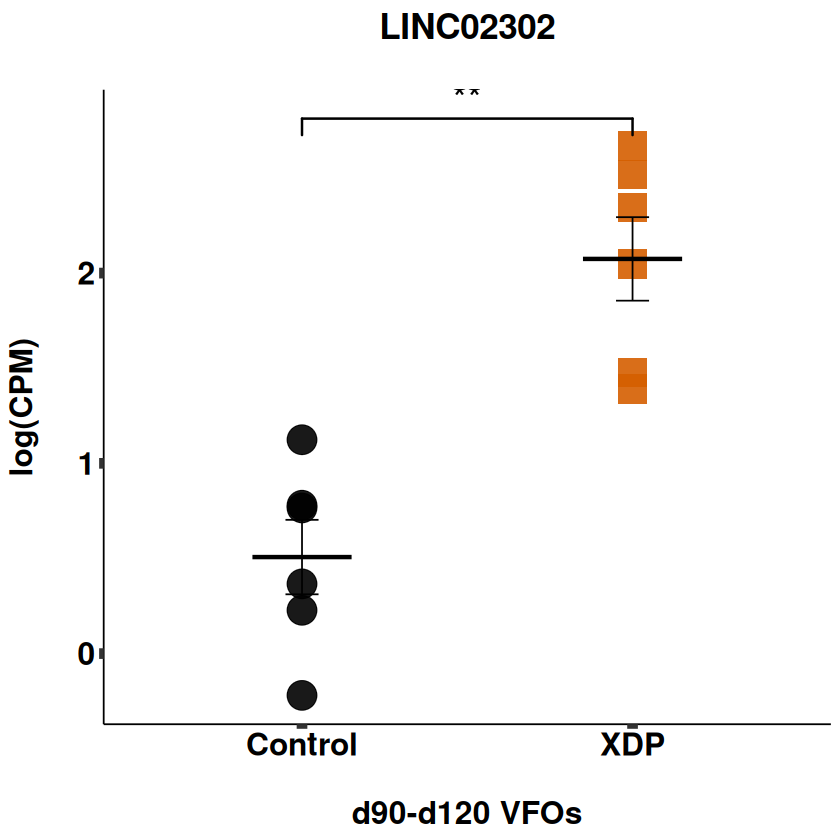

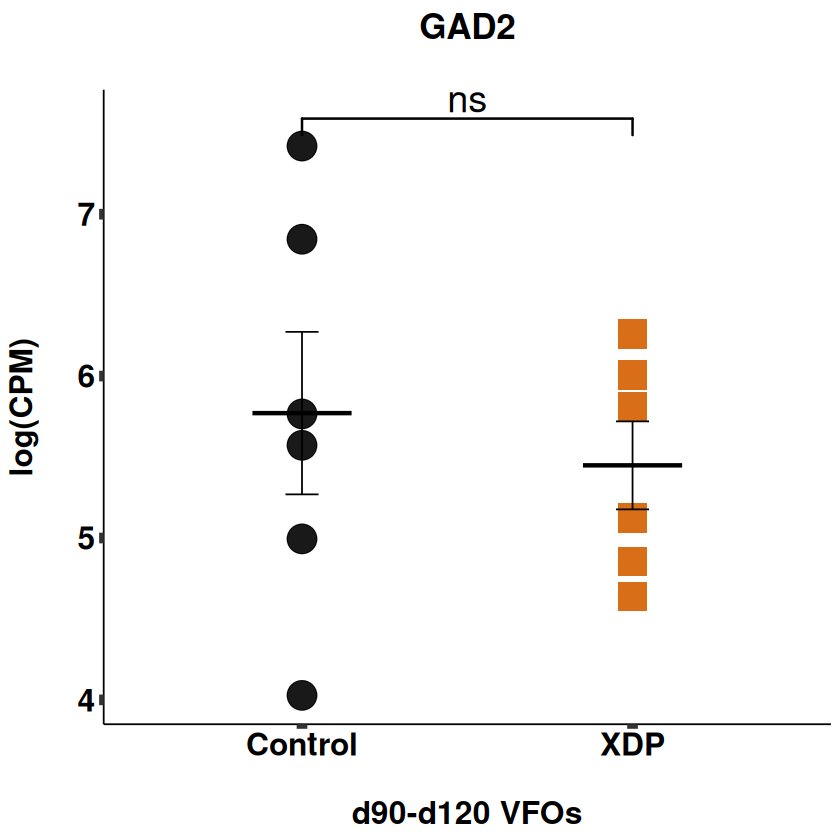

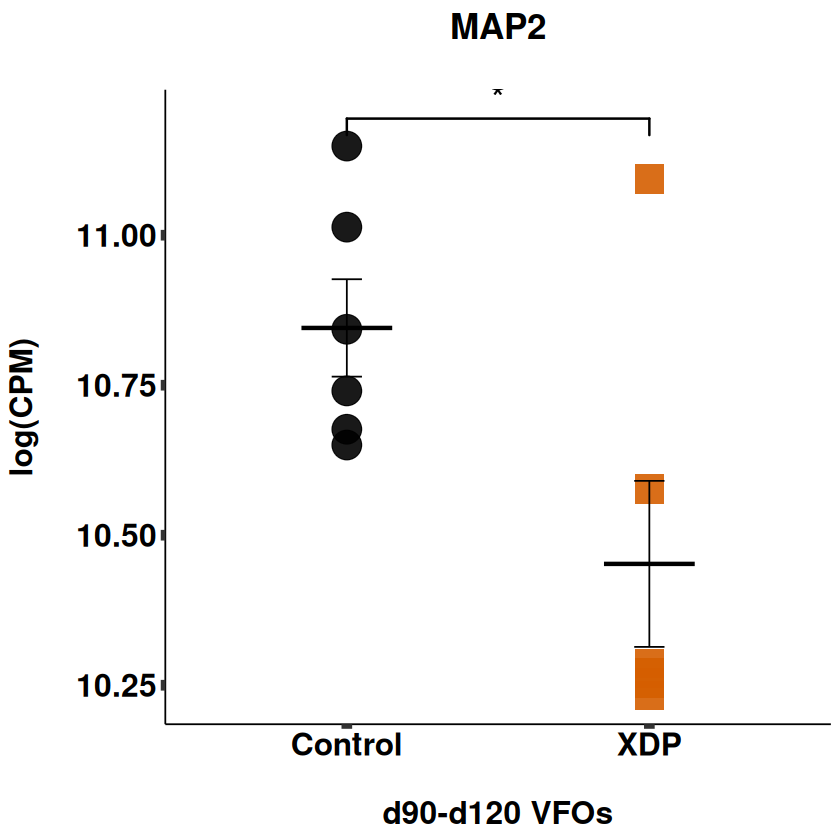

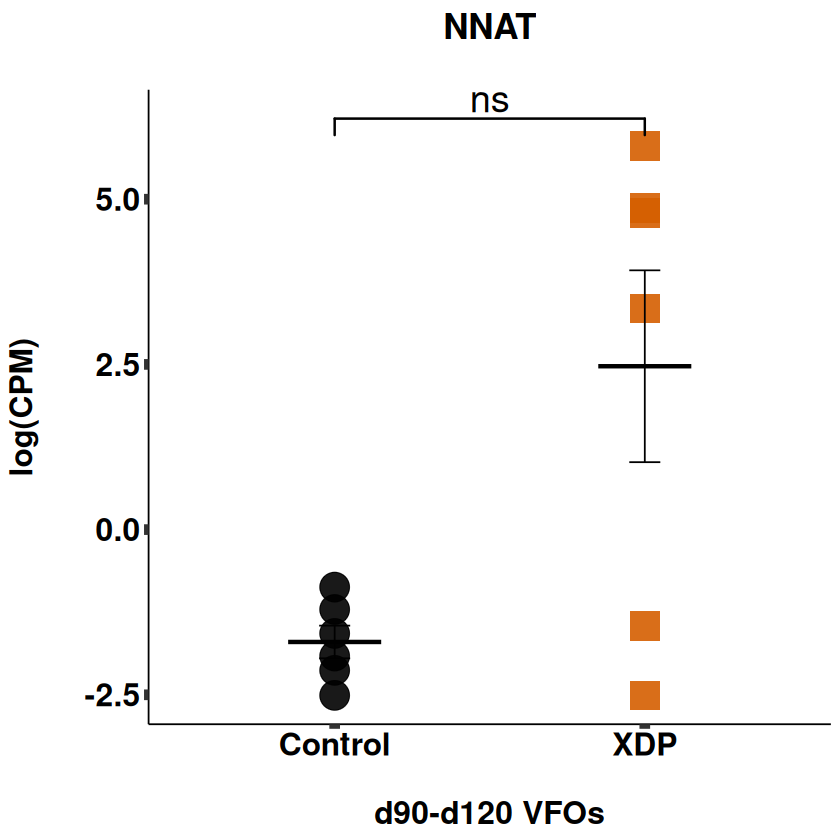

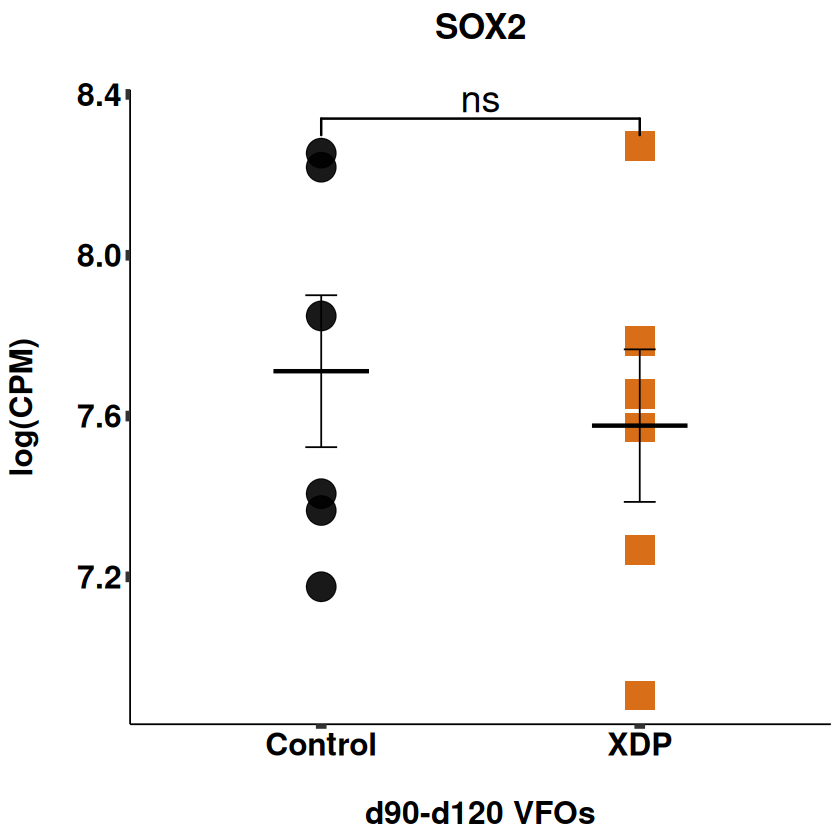

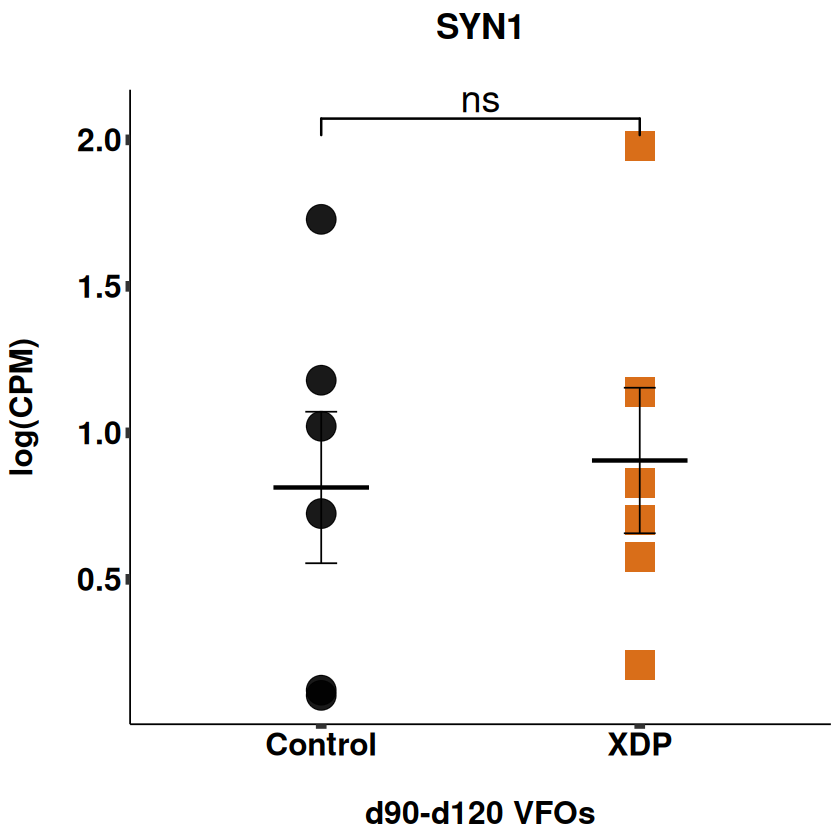

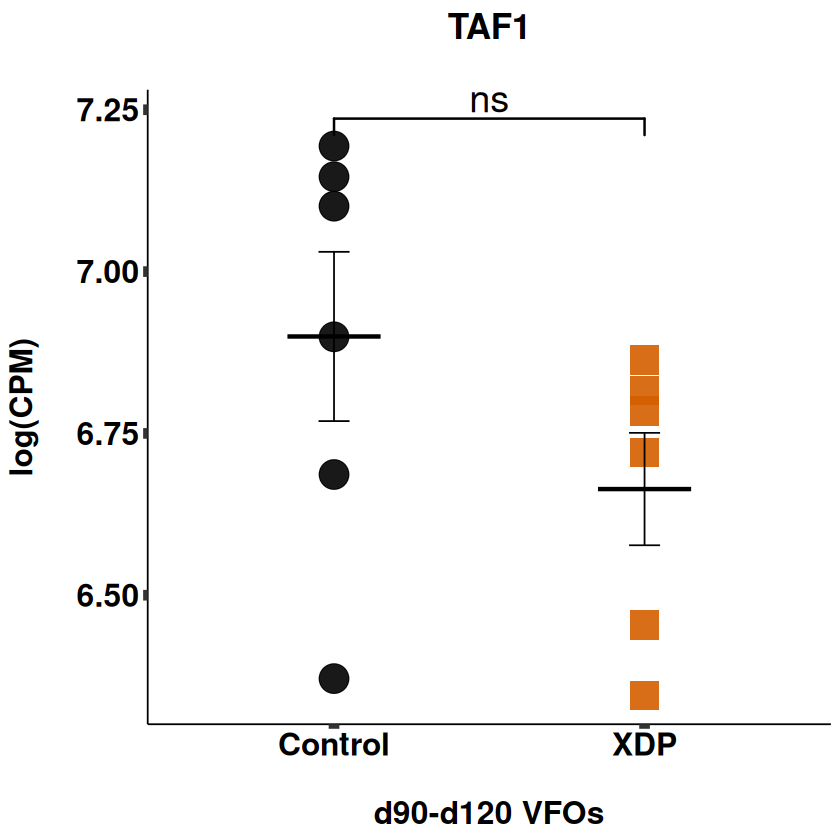

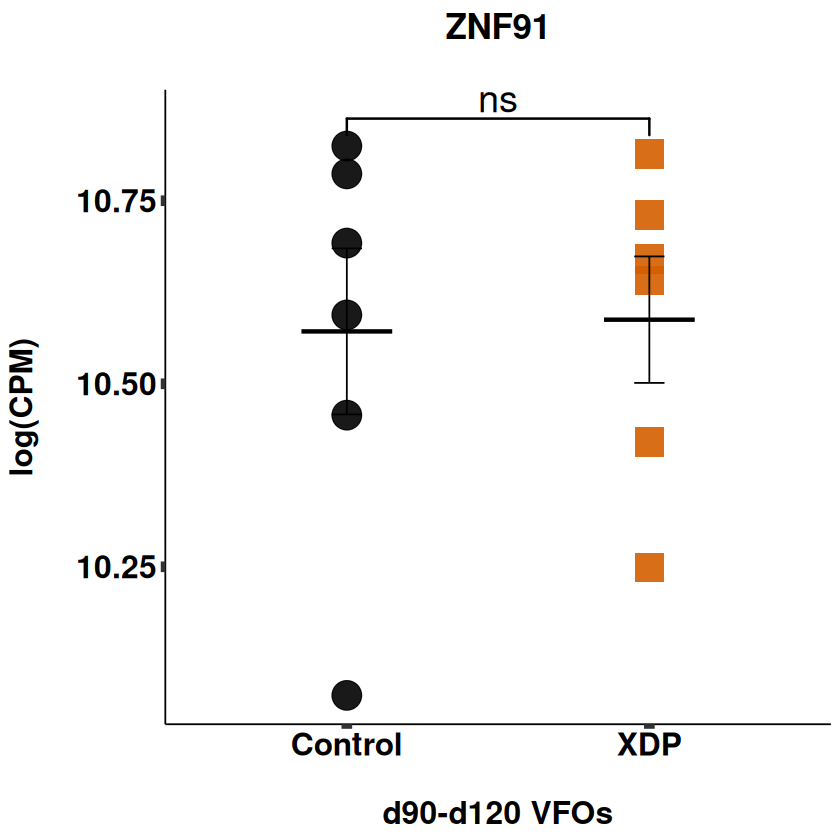

In [21]:

# significant ones: CASP1, MAP2
#my_pvalue <- 0.998
for (gene in genes_list){



    subset_data <- subset(new_plot_input, Symbol == gene) #%>% na.omit()
    color_pal <- c("black", "#D55E00")
    mycomp <- list(c('Control', 'XDP')) #change here if necessary

    p1 <- ggplot(subset_data, aes(x = Cell_line, y = value, color = Cell_line, shape = Cell_line)) + 
                geom_point(size = 8, alpha = 0.9) +
                scale_shape_manual(values = c(19, 15)) + #ylim(6, 8) +
                stat_summary(fun.data = mean_cl_normal, 
                             fun.args = list(mult = 1),
                             geom = "errorbar",
                             color = "black",
                             width = 0.1,
                             linetype = "solid"
                             ) +
                stat_summary(fun = "mean",
                             fun.args = list(mult = 1),
                             geom = "crossbar",
                             color = "black",
                             width = 0.3
                             ) +
                scale_color_manual(values = color_pal) +
                labs(title = paste0(gene,'\n'), x = '\nd90-d120 VFOs', y = 'log(CPM)\n') + #change here if necessary
                stat_compare_means(
                        aes(label = ..p.signif..),
                        size = 8,
                        comparisons = mycomp,
                        bracket.size = 0.7,
                        method = 'wilcox.test') +
                theme_custom +
                #annotate("text", x = 1.5, y = 7.5, label = paste0("FDR = ", my_pvalue), size = 5, parse = TRUE) +
                guides(color = 'none', shape = 'none') #remove legend


    plot(p1)
    save_plot(p = p1,
              fn = paste0(save_path,'Mature_organoids_male_comparison_design1_deseq2_dotplot_NS_',gene),
              w = 7,
              h = 11)
    }

# create along all days dotplot (control, deltasva and xdp)

In [22]:
save_path <- './alldays_male_controldeltaxdp/'
dir.create(save_path)

In [23]:
metadata_filtered <- metadata %>%
                        filter(RIN >= 6) %>%
                        filter(grepl('^Control$|^XDP$|^DELTA-SVA-XDP$',Cell_line))

metadata_filtered %>% head()

metadata_filtered$Cell_line %>% table

metadata_filtered$Sex %>% table

Differentiation_cohort,Sample,iPSC_line,Cell_line,Sex,Day_of_Maturation,RIN,Kit,Disease_Status,individual
<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>
A,1N,33113.2I,Control,Male,30,8.7,Zymo_R2062,healthy,33113
A,2N,33109.2G,XDP,Male,30,8.0,Zymo_R2062,patient,33109
A,3N,33109.2G-1A4,DELTA-SVA-XDP,Male,30,9.0,Zymo_R2062,healthy,33109
A,4N,33109.2G-2F2,DELTA-SVA-XDP,Male,30,8.8,Zymo_R2062,healthy,33109
A,5N,33113.2I,Control,Male,60,7.6,Zymo_R2062,healthy,33113
A,6N,33109.2G,XDP,Male,60,7.6,Zymo_R2062,patient,33109


.
Carrier-Control  Carrier-Mutant         Control   DELTA-SVA-XDP             XDP 
              0               0              12              15              11 

.
Female   Male 
     0     38 

In [24]:
#logcpm
rse <- merge_with_metadata(rse_gene, metadata_filtered)

#rse_gene# extract counts matrix
counts_mat <- assay(rse)
# calculate log CPM values
log_cpm_mat <- cpm(counts_mat, log = TRUE)
# set the assay names
assayNames(rse) <- c("logcpm")
# add log CPM as a new assay
assay(rse, "logcpm") <- log_cpm_mat


plot_input <- assay(rse, "logcpm") %>%
                            as.data.frame() %>%
                            tibble::rownames_to_column() %>%
                            data.table::as.data.table() %>%
                            data.table::melt() %>%
                            left_join(rse@rowRanges %>% as.data.frame(), by=c('rowname'='gencodeID')) %>%
                            left_join(metadata_filtered[,1:10], by=c('variable'='Sample'))


df <- data.frame()

for (i in seq_along(deseq2_files)){

    
    dftmp <- fread(deseq2_files[i]) %>%
                        select(ROW_INDEX)
    df <- rbind(dftmp,df)   
    
    }

df <- df %>% distinct(ROW_INDEX)



for (i in seq_along(deseq2_files)){
    dftmp <- fread(deseq2_files[i]) %>%
                select(ROW_INDEX, padj) %>%
                rename_with(~model_tag[i],.cols = padj)
    
    df <- left_join(dftmp,df)
    }


new_plot_input <- left_join(plot_input, df, by=c('rowname'='ROW_INDEX'))

Warning message in melt.data.table(.):
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [rowname, ...]. Consider providing at least one of 'id' or 'measure' vars in future.”


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


Joining with `by = join_by(ROW_INDEX)`


In [25]:
newdf <- new_plot_input %>% 
                        select(c(Symbol, starts_with('Day'))) %>%
                        select(-2) %>%
                        filter(Symbol %in% genes_list) %>%
                        #t() %>%
                        data.table::as.data.table() %>%
                        data.table::melt() %>%
                        filter(value < 0.05)

Warning message in melt.data.table(.):
“id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Symbol, ...]. Consider providing at least one of 'id' or 'measure' vars in future.”


In [26]:
deseq2_pvals <- newdf %>% 
                    distinct(Symbol, variable,.keep_all = T) %>%
                    arrange(Symbol, variable) %>%
                    mutate(Day = gsub("_.*", "", variable),
                           Comp = gsub(".*Pairwise_|_deseq2","",variable))

# deseq2_pvals$Comp <- elements <- c('control x delta', 
#                                   'delta x xdp', 
#                                   'control x delta', 
#                                   'control x xdp', 
#                                   'control x delta', 
#                                   'control x xdp', 
#                                   'delta x xdp', 
#                                   'control x delta', 
#                                   'control x delta', 
#                                   'control x xdp', 
#                                   'control x delta')

colnames(deseq2_pvals)[3] <- 'deseq2_adjPval'

deseq2_pvals 

fwrite(deseq2_pvals, paste0(save_path, 'deseq2_SIGNIFICANT_ADJPVALUES.tsv'), sep = '\t', quote=F)

Symbol,variable,deseq2_adjPval,Day,Comp
<chr>,<fct>,<dbl>,<chr>,<chr>
CALB1,Day120_All_Male_Pairwise_deltaxdp_deseq2,2.106650e-02,Day120,deltaxdp
DRD1,Day60_All_Male_Pairwise_controldelta_deseq2,8.012307e-03,Day60,controldelta
DRD1,Day120_All_Male_Pairwise_controlxdp_deseq2,4.612900e-03,Day120,controlxdp
DRD1,Day120_All_Male_Pairwise_controldelta_deseq2,1.080868e-14,Day120,controldelta
GAD2,Day30_All_Male_Pairwise_controlxdp_deseq2,1.904589e-02,Day30,controlxdp
NNAT,Day60_All_Male_Pairwise_deltaxdp_deseq2,5.117947e-05,Day60,deltaxdp
NNAT,Day60_All_Male_Pairwise_controldelta_deseq2,2.702682e-03,Day60,controldelta


In [27]:
plot_input <- new_plot_input %>%
                        #filter(grepl('^Control$|^XDP$',Cell_line), grepl('30|60|90|120',Day_of_Maturation)) %>%
                        mutate(new_labels = factor(paste0(Cell_line,' d',Day_of_Maturation),
                                                  levels = c('Control d30', 'XDP d30', 'DELTA-SVA-XDP d30',
                                                             'Control d60', 'XDP d60', 'DELTA-SVA-XDP d60', 
                                                             'Control d90', 'XDP d90', 'DELTA-SVA-XDP d90', 
                                                             'Control d120', 'XDP d120', 'DELTA-SVA-XDP d120')
                                                  )
                               )



In [28]:
#new_plot_input %>% colnames()

In [29]:
plot_input$new_labels %>% head()

[1] DELTA-SVA-XDP d90 DELTA-SVA-XDP d90 DELTA-SVA-XDP d90 DELTA-SVA-XDP d90
[5] DELTA-SVA-XDP d90 DELTA-SVA-XDP d90
12 Levels: Control d30 XDP d30 DELTA-SVA-XDP d30 Control d60 ... DELTA-SVA-XDP d120

In [30]:
# c('ZNF728', 
# 'LINC01535',
# 'ZNF835', 
# 'ENSG00000290122',
# 'UNC5D',
# 'LINC02987',
# 'MIR4458HG',
# 'LINC02969',
# 'LERFS',
# 'HLA-A',
# 'ENSG00000279267',
# 'ENSG00000272812',
# 'U3',
# 'ZNF667-AS1',
# 'CDK10',
# 'ZNF471',
# 'TAS2R43',
# 'ENSG00000274471',
# 'SMG1P5',
# 'ENSG00000251379',
# 'ZNF22',
# 'TTC4')


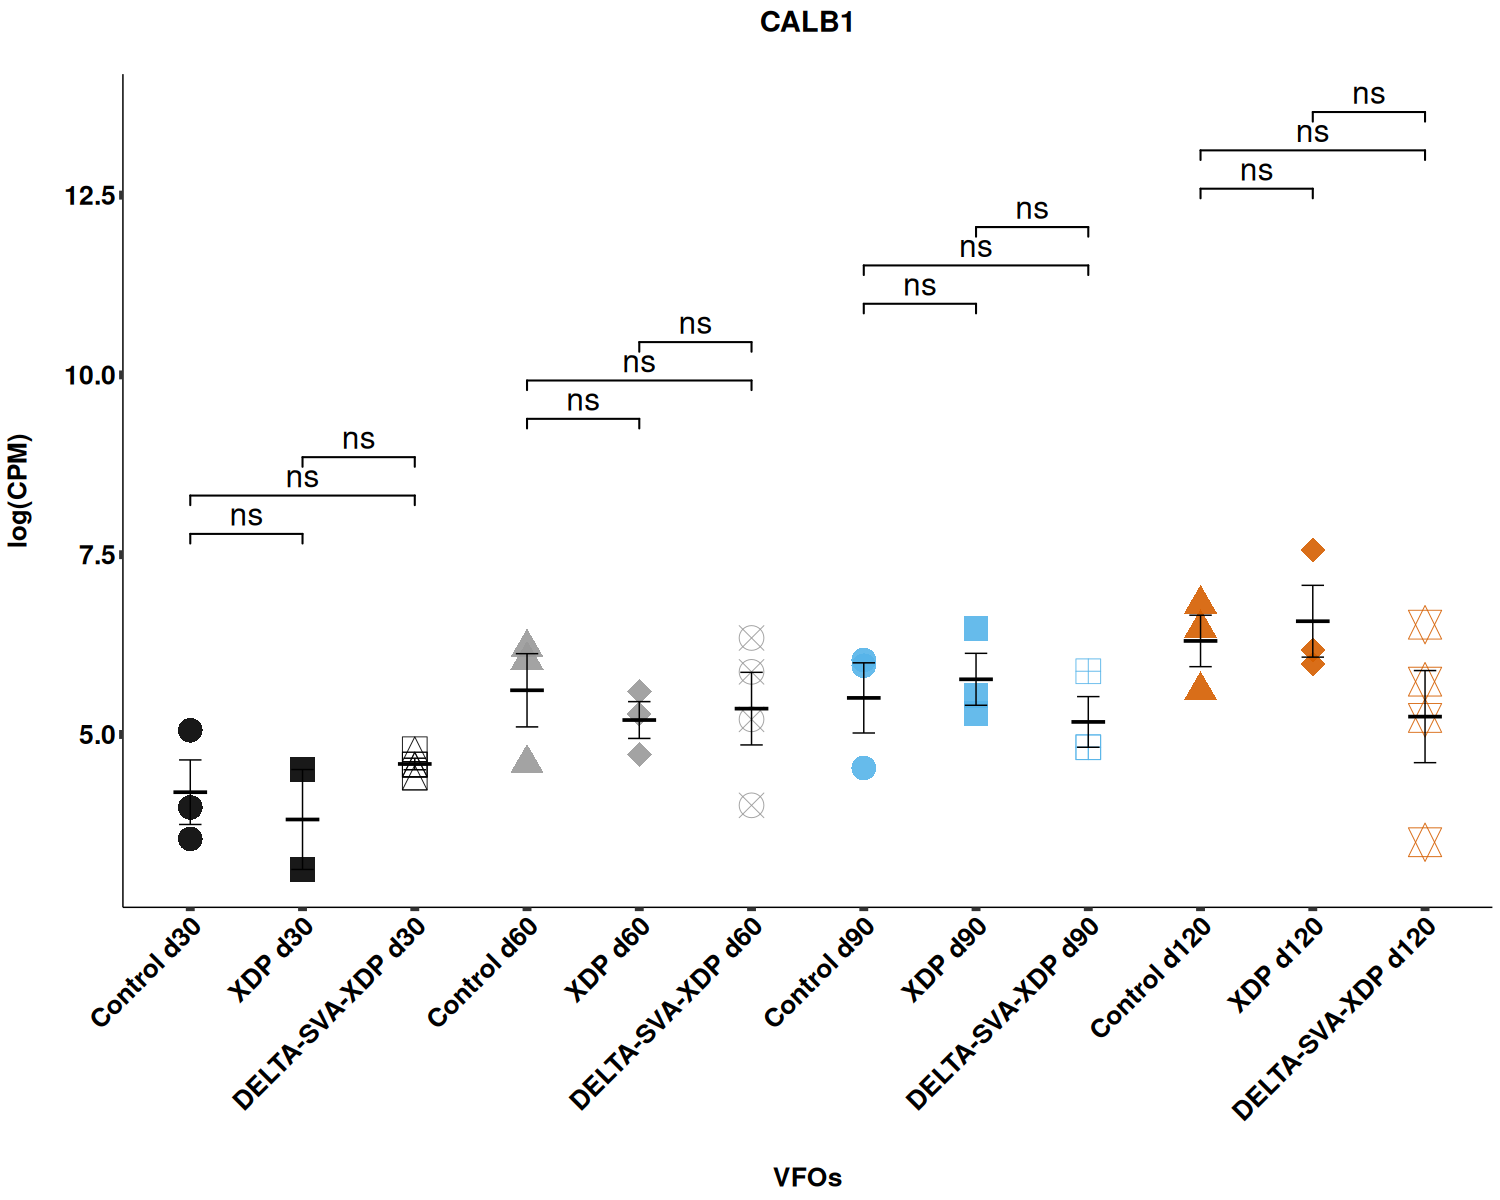

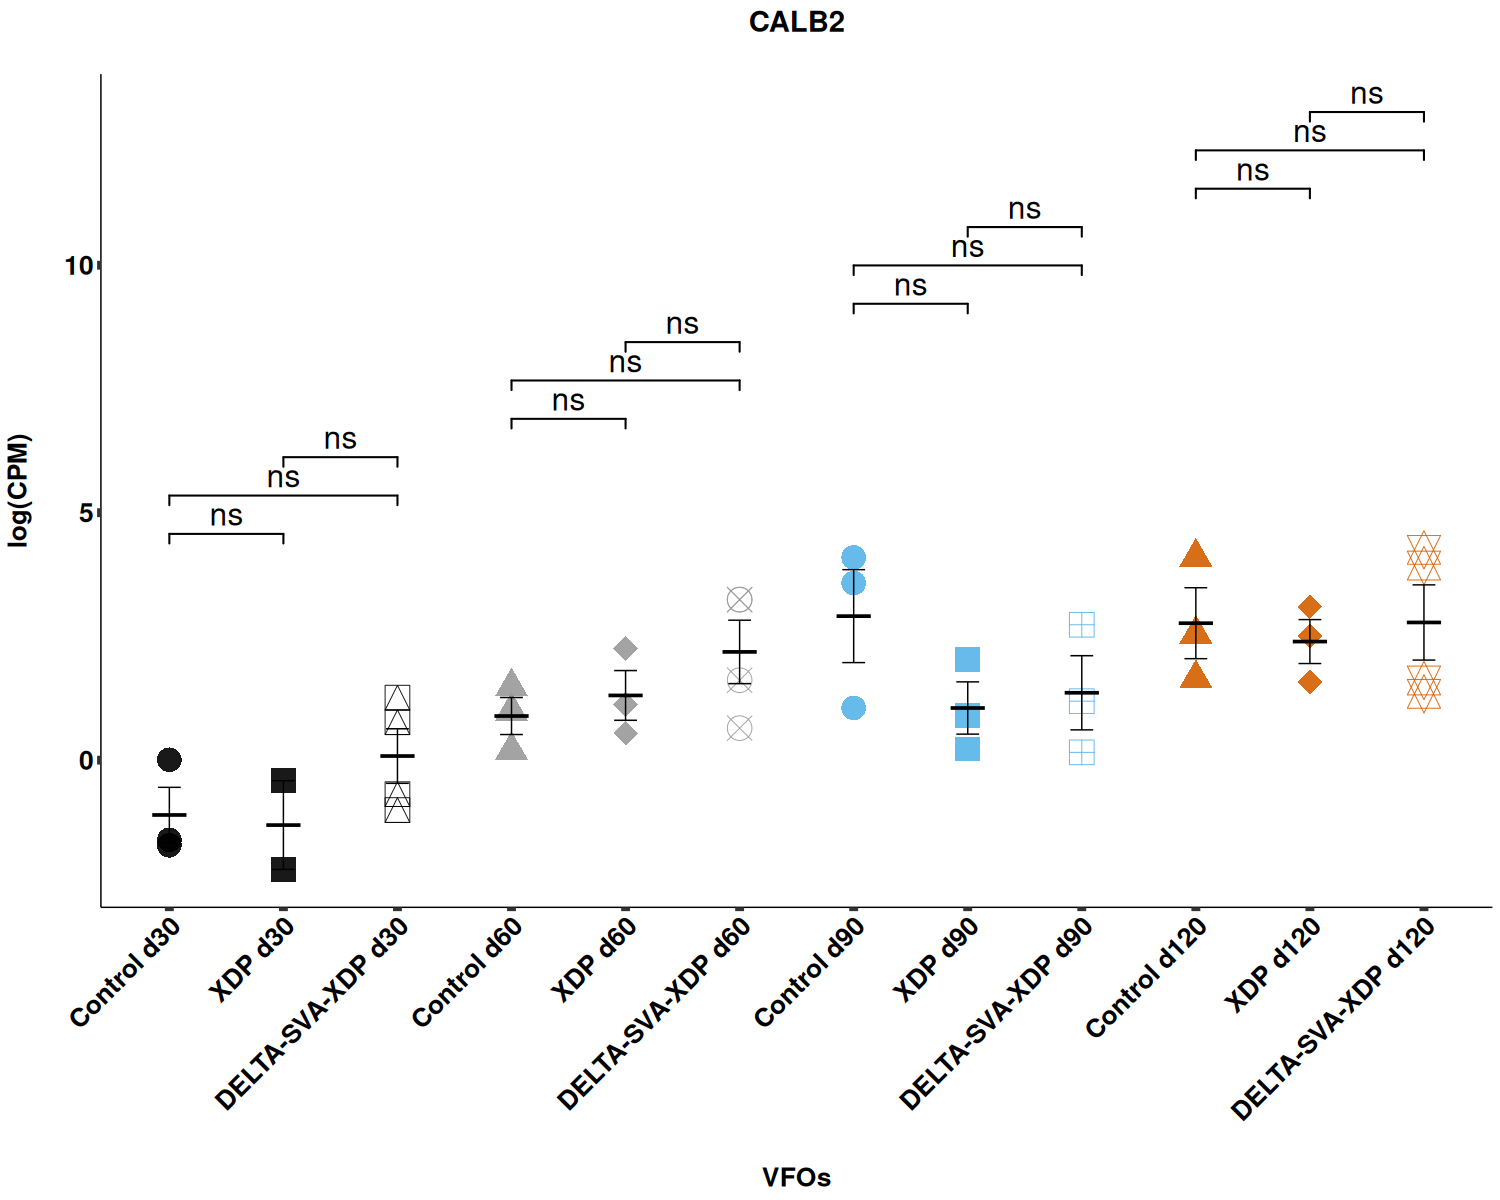

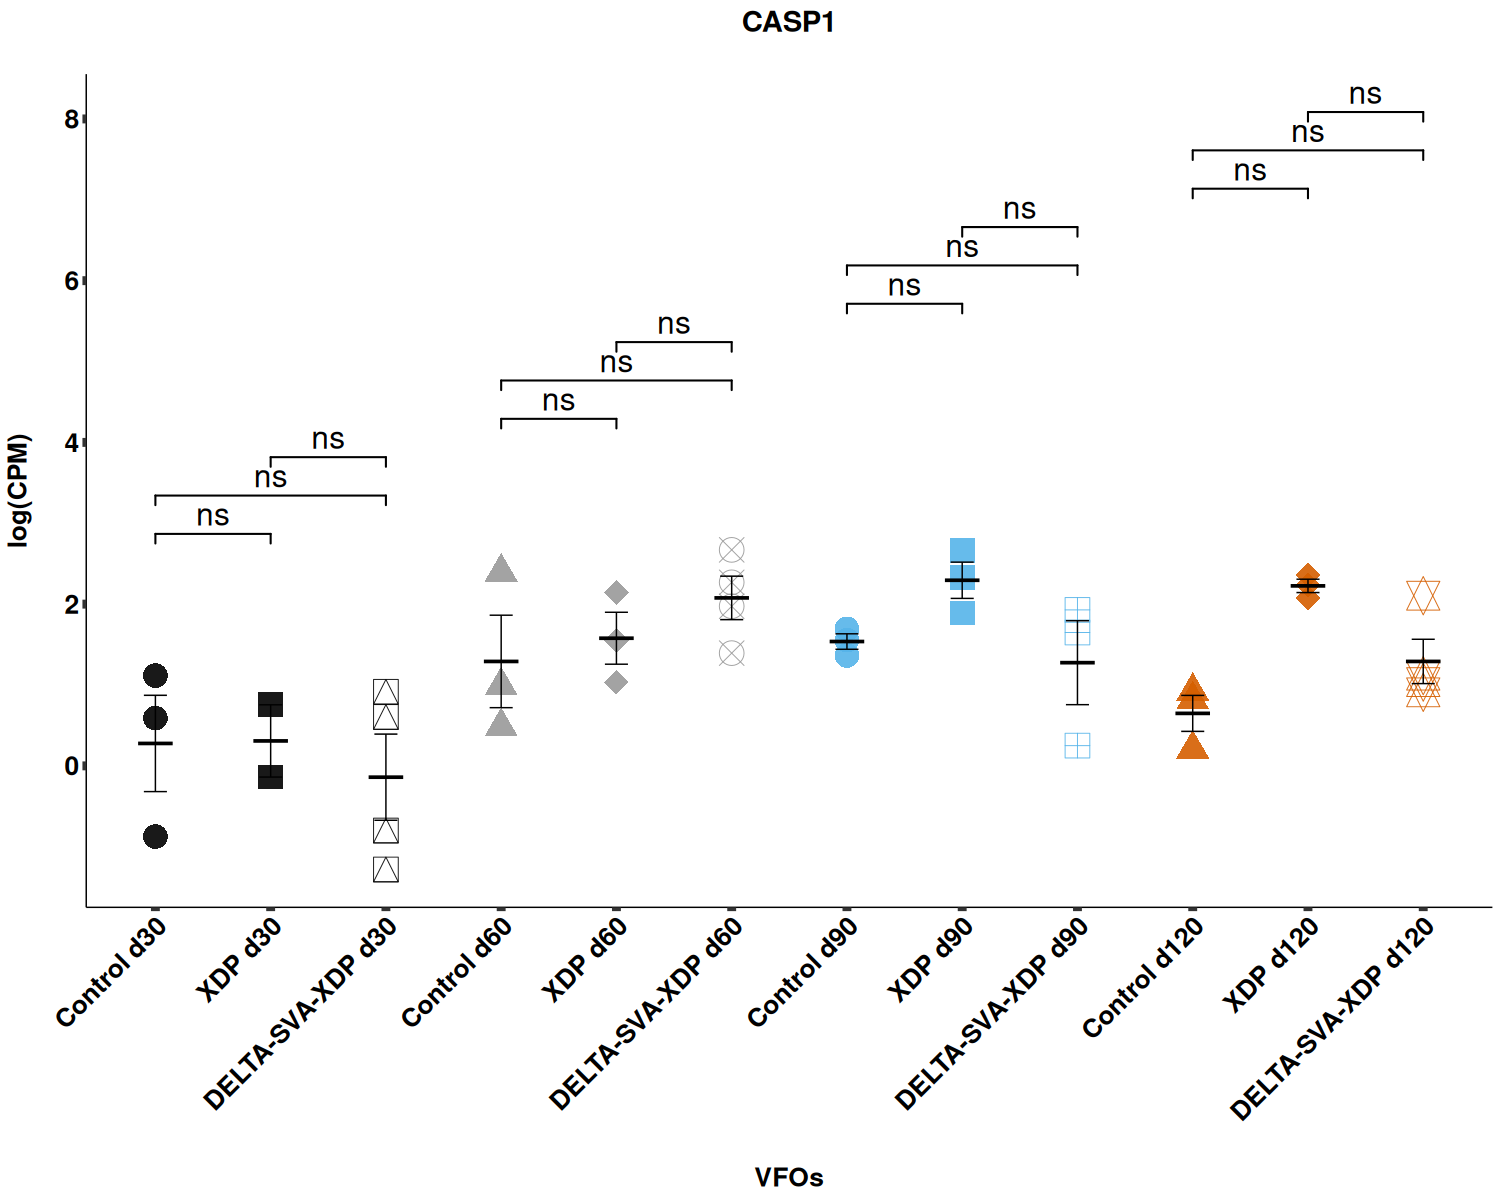

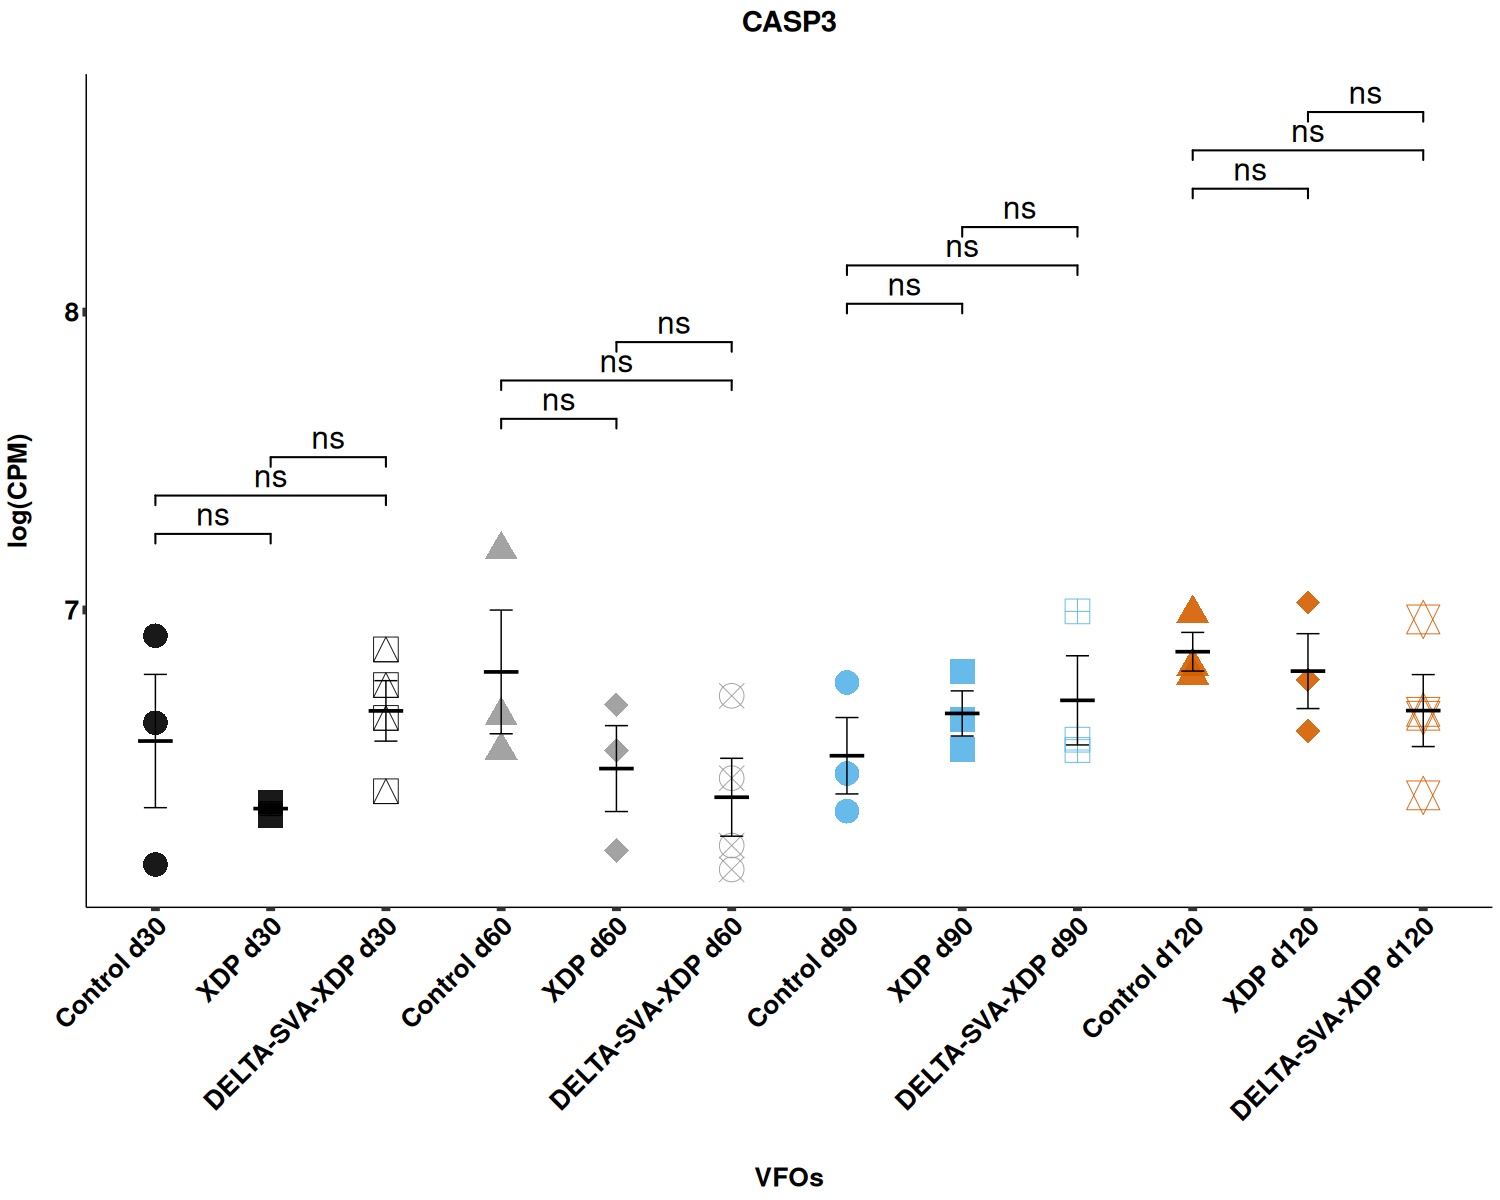

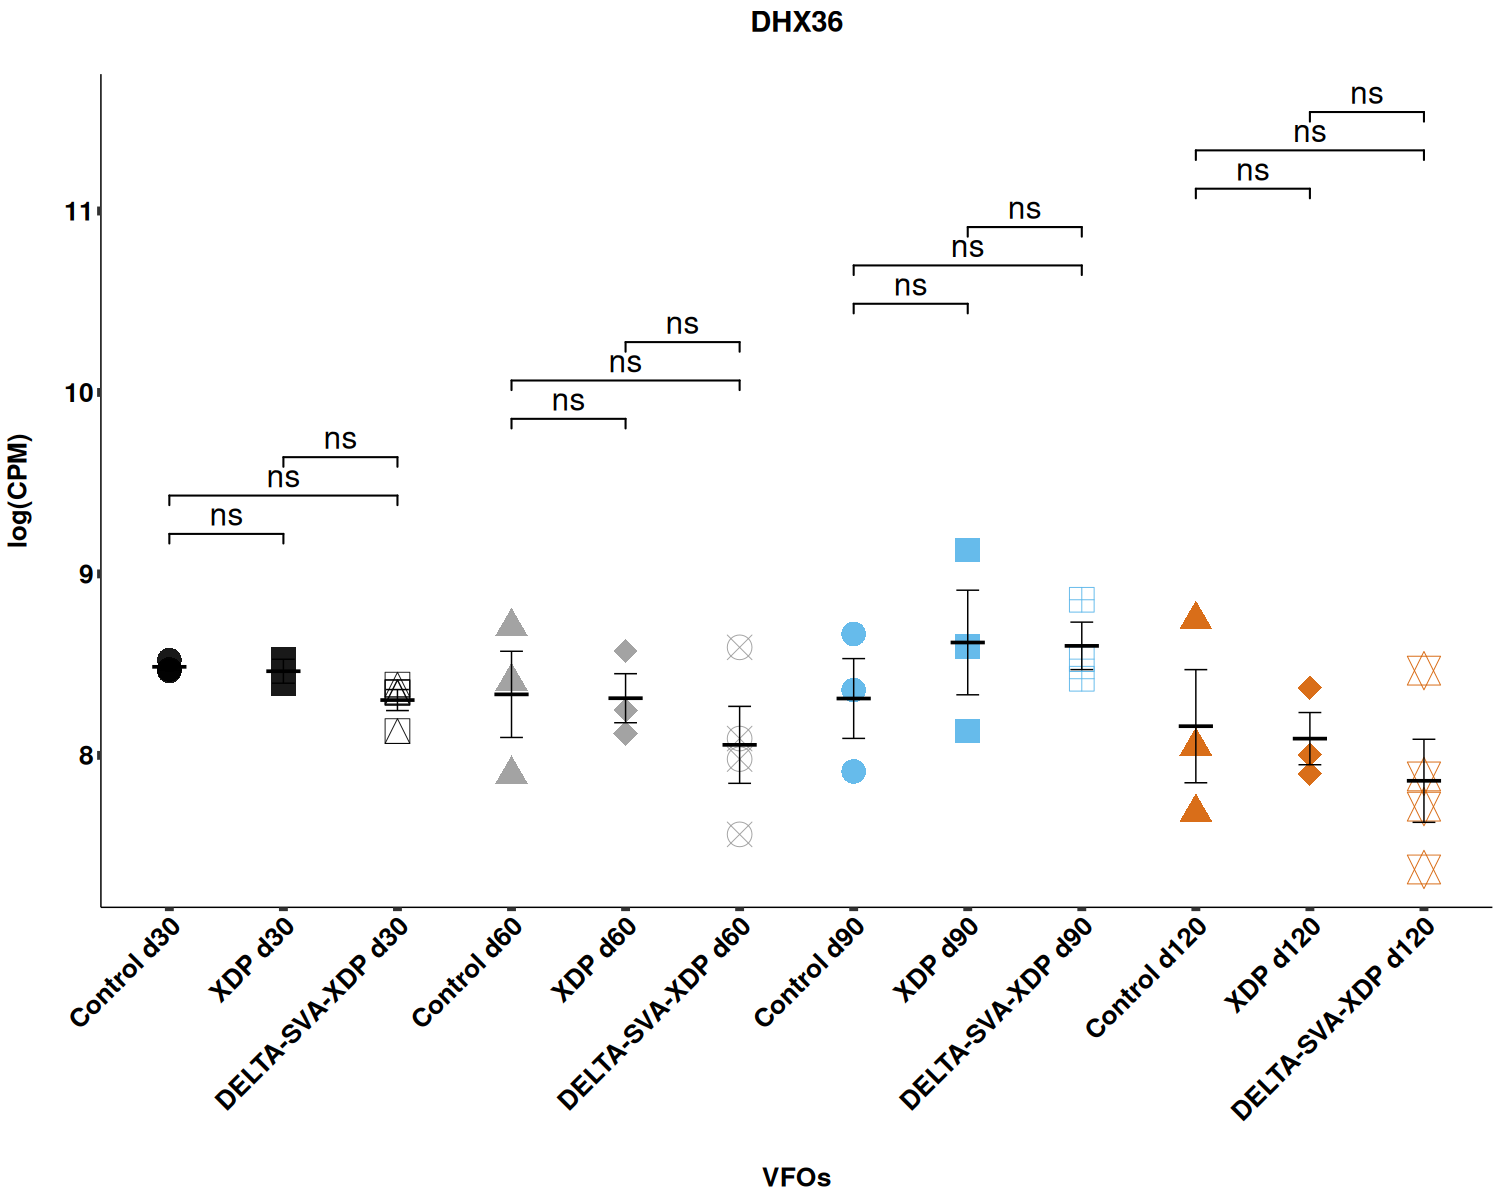

Warning message in wilcox.test.default(c(-1.69710988224001, -0.994657343484491, :
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.56037962107559, -2.70384627384234, -1.24293917422967:
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.56037962107559, -2.70384627384234, -1.24293917422967:
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.79055946415011, -2.13619131703498, -2.70384627384234:
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.69710988224001, -0.994657343484491, :
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.56037962107559, -2.70384627384234, -1.24293917422967:
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.56037962107559, -2.70384627384234, -1.24293917422967:
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.79055946415011, -2.13619131703498, -2.70384627384234:
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.69710988224001, -0.994657343484491, :
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.56037962107559, -2.70384627384234, -1.24293917422967:
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.56037962107559, -2.70384627384234, -1.24293917422967:
“cannot compute exact p-value with ties”


Warning message in wilcox.test.default(c(-1.79055946415011, -2.13619131703498, -2.70384627384234:
“cannot compute exact p-value with ties”


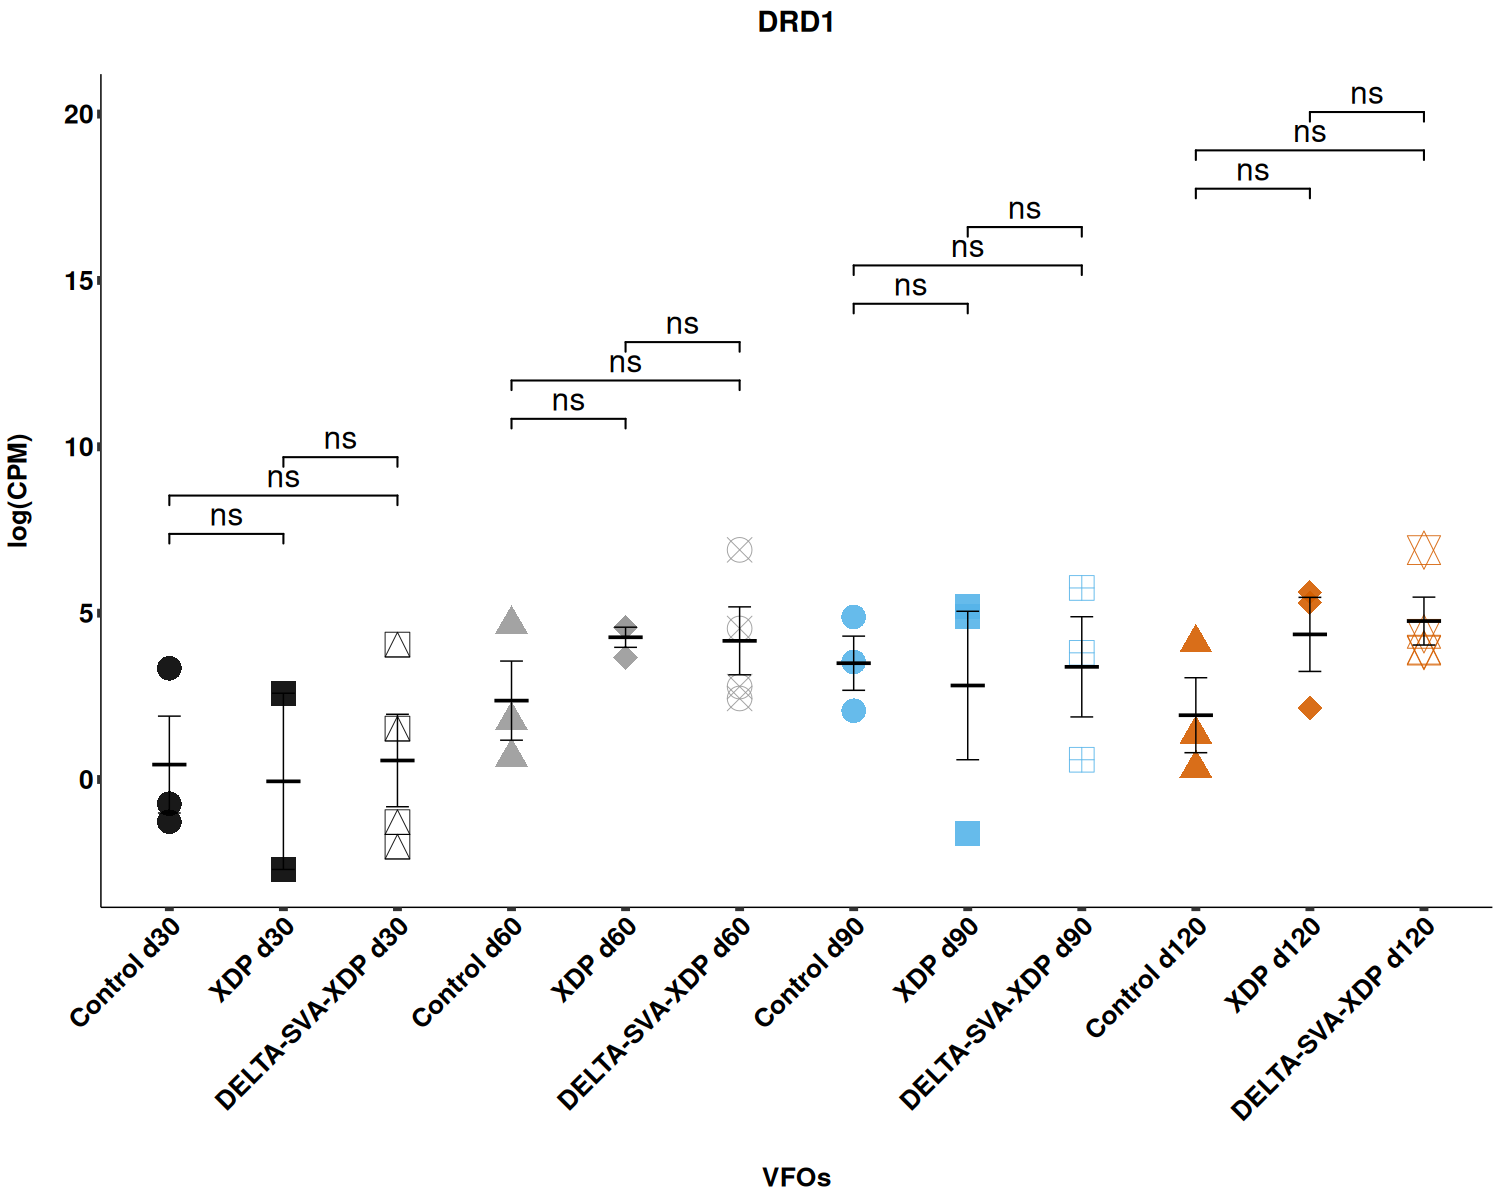

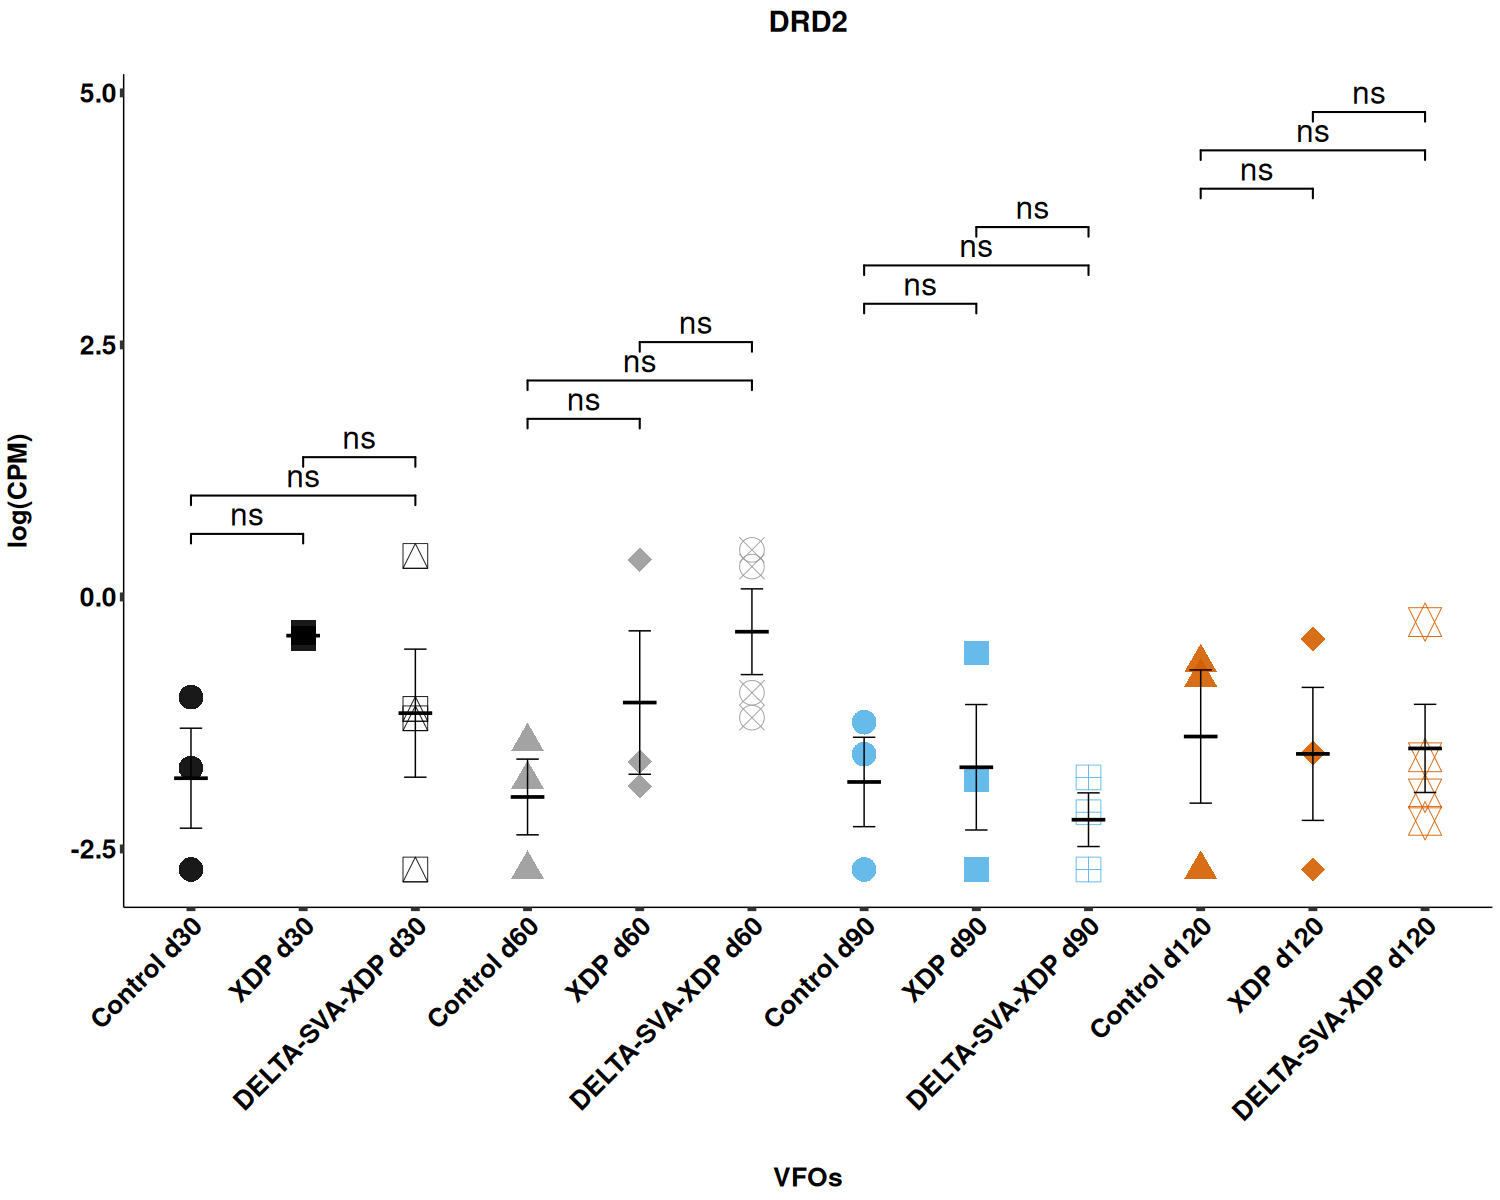

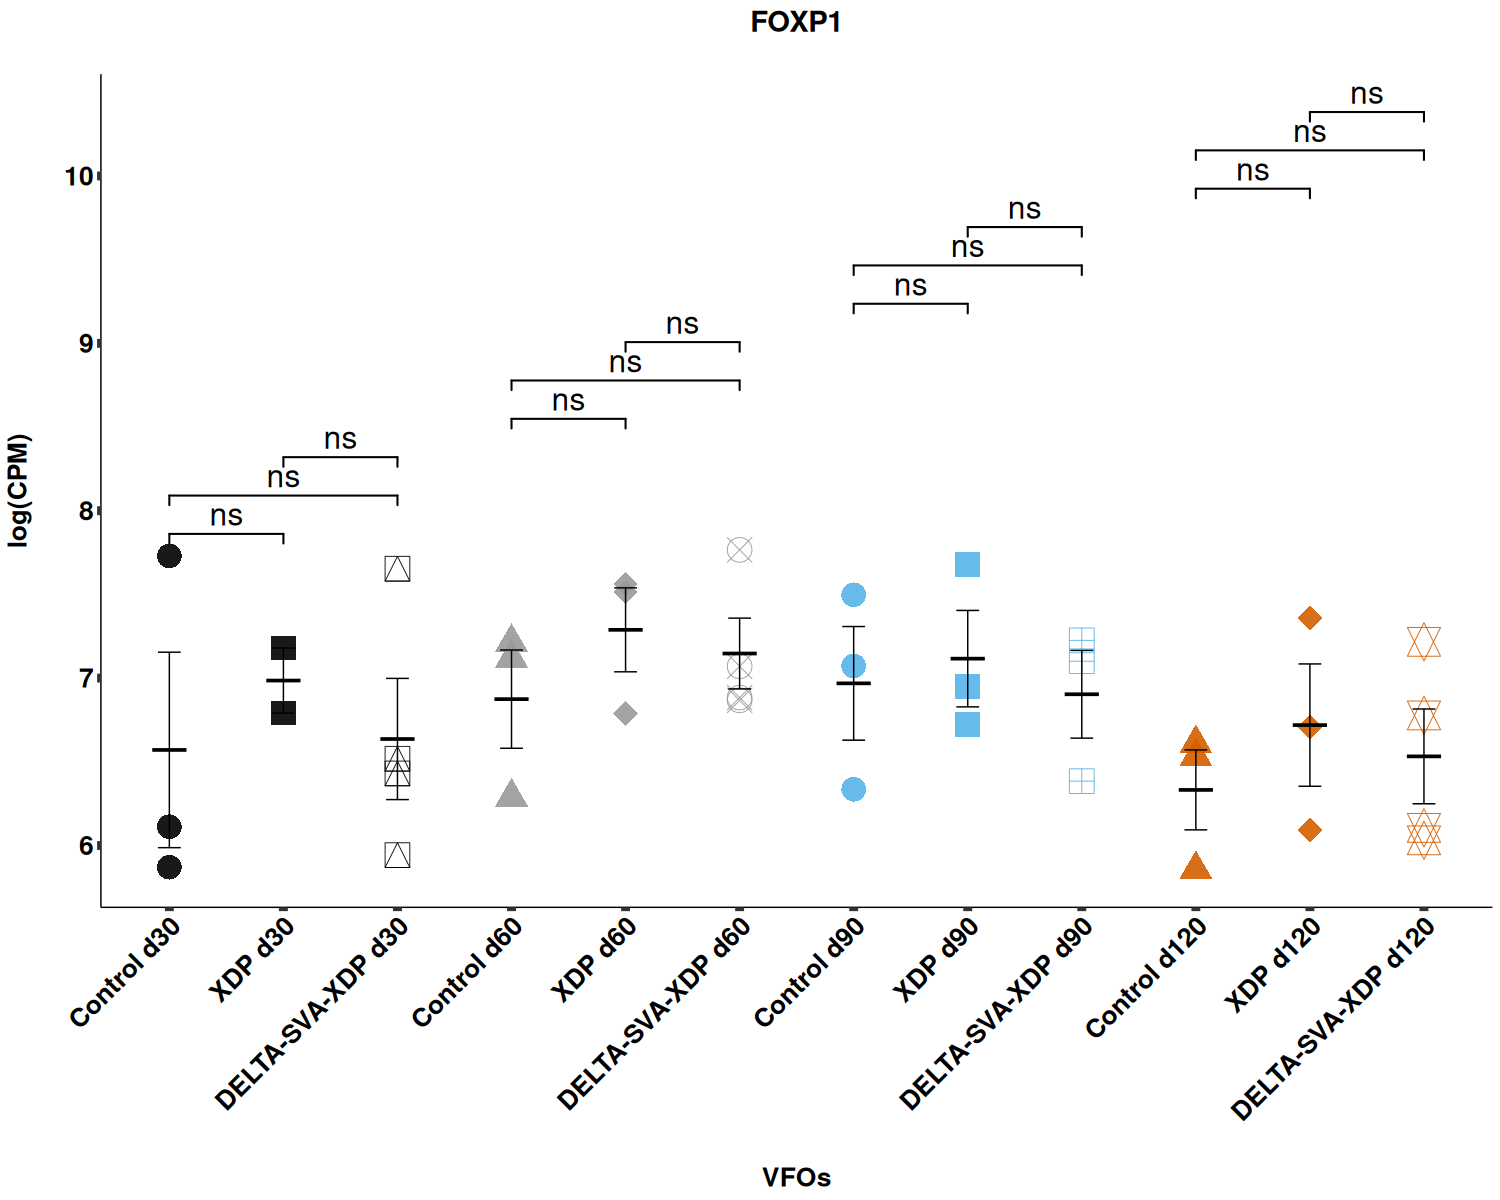

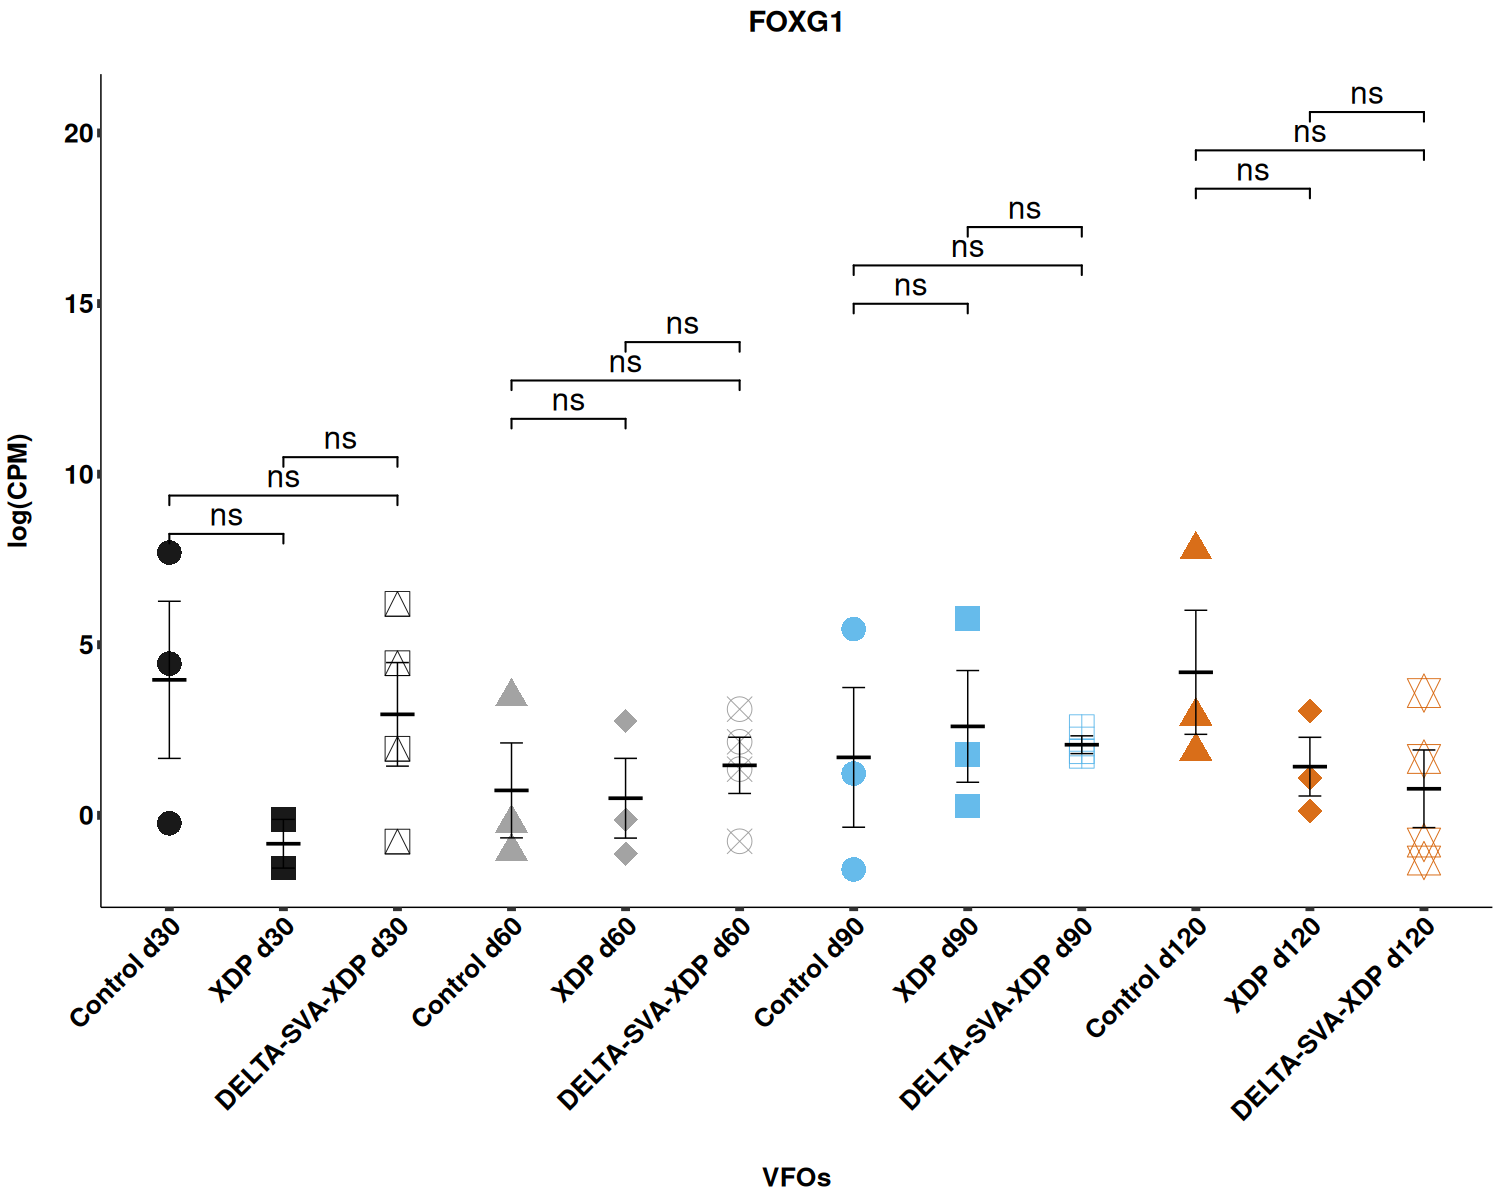

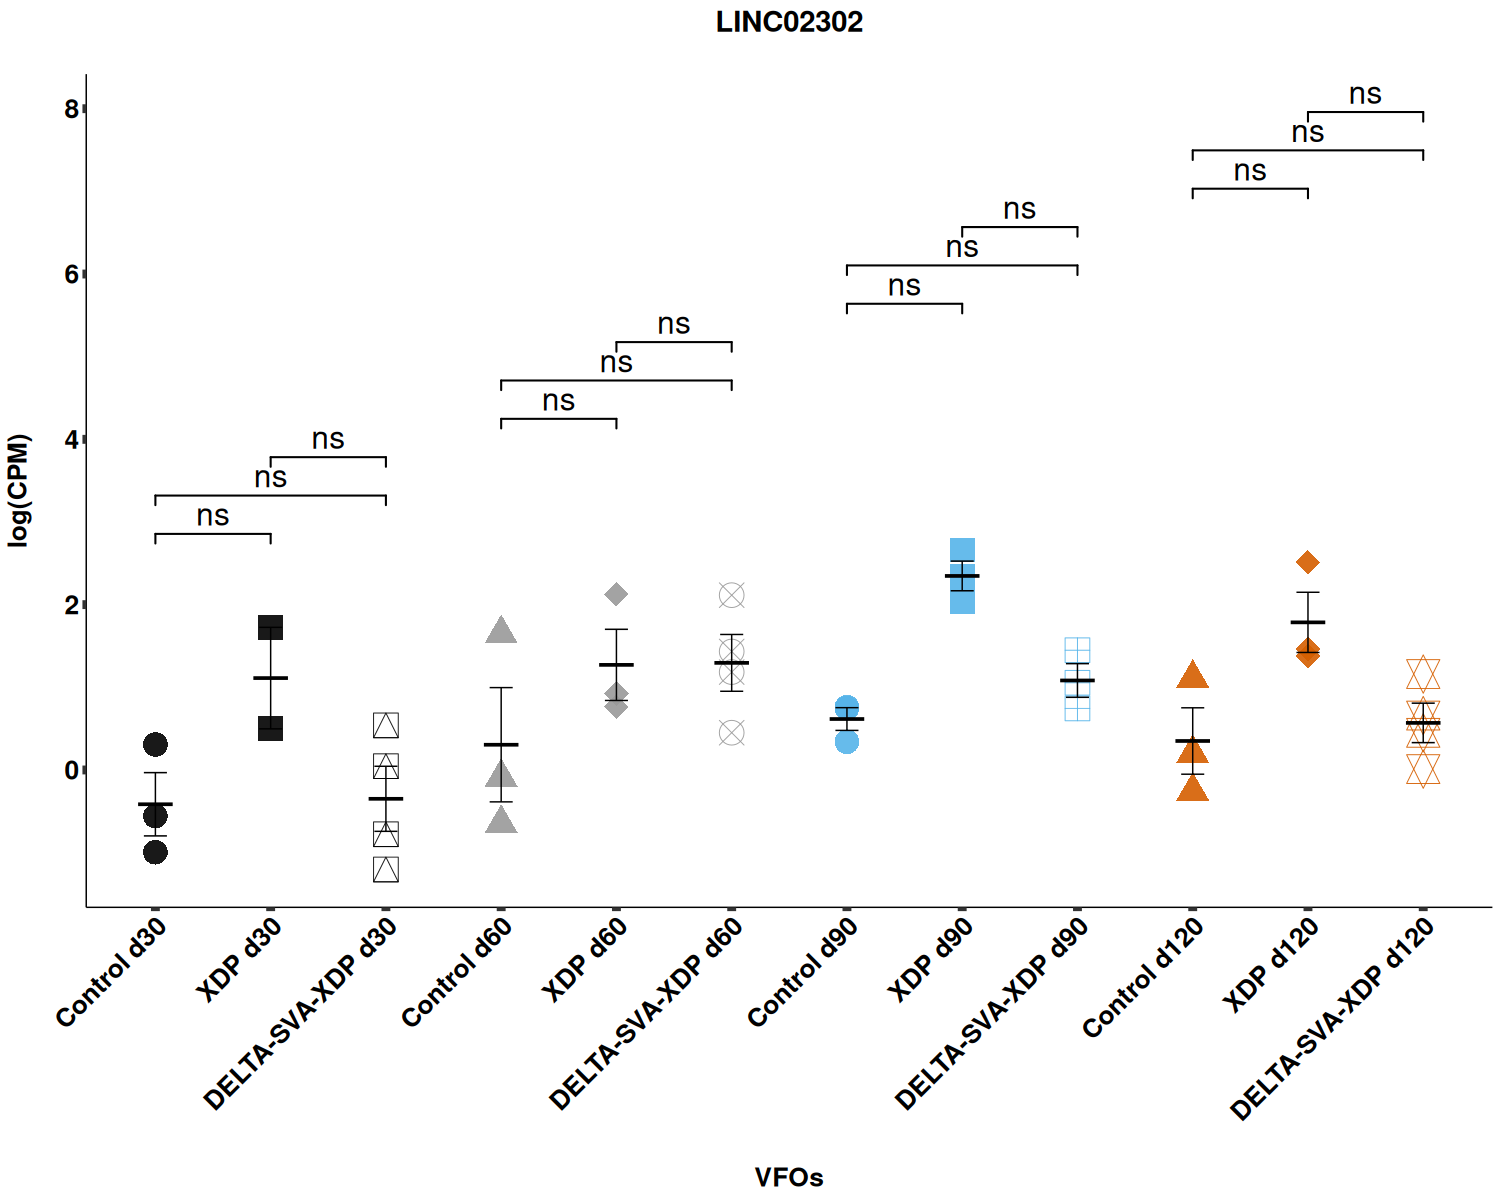

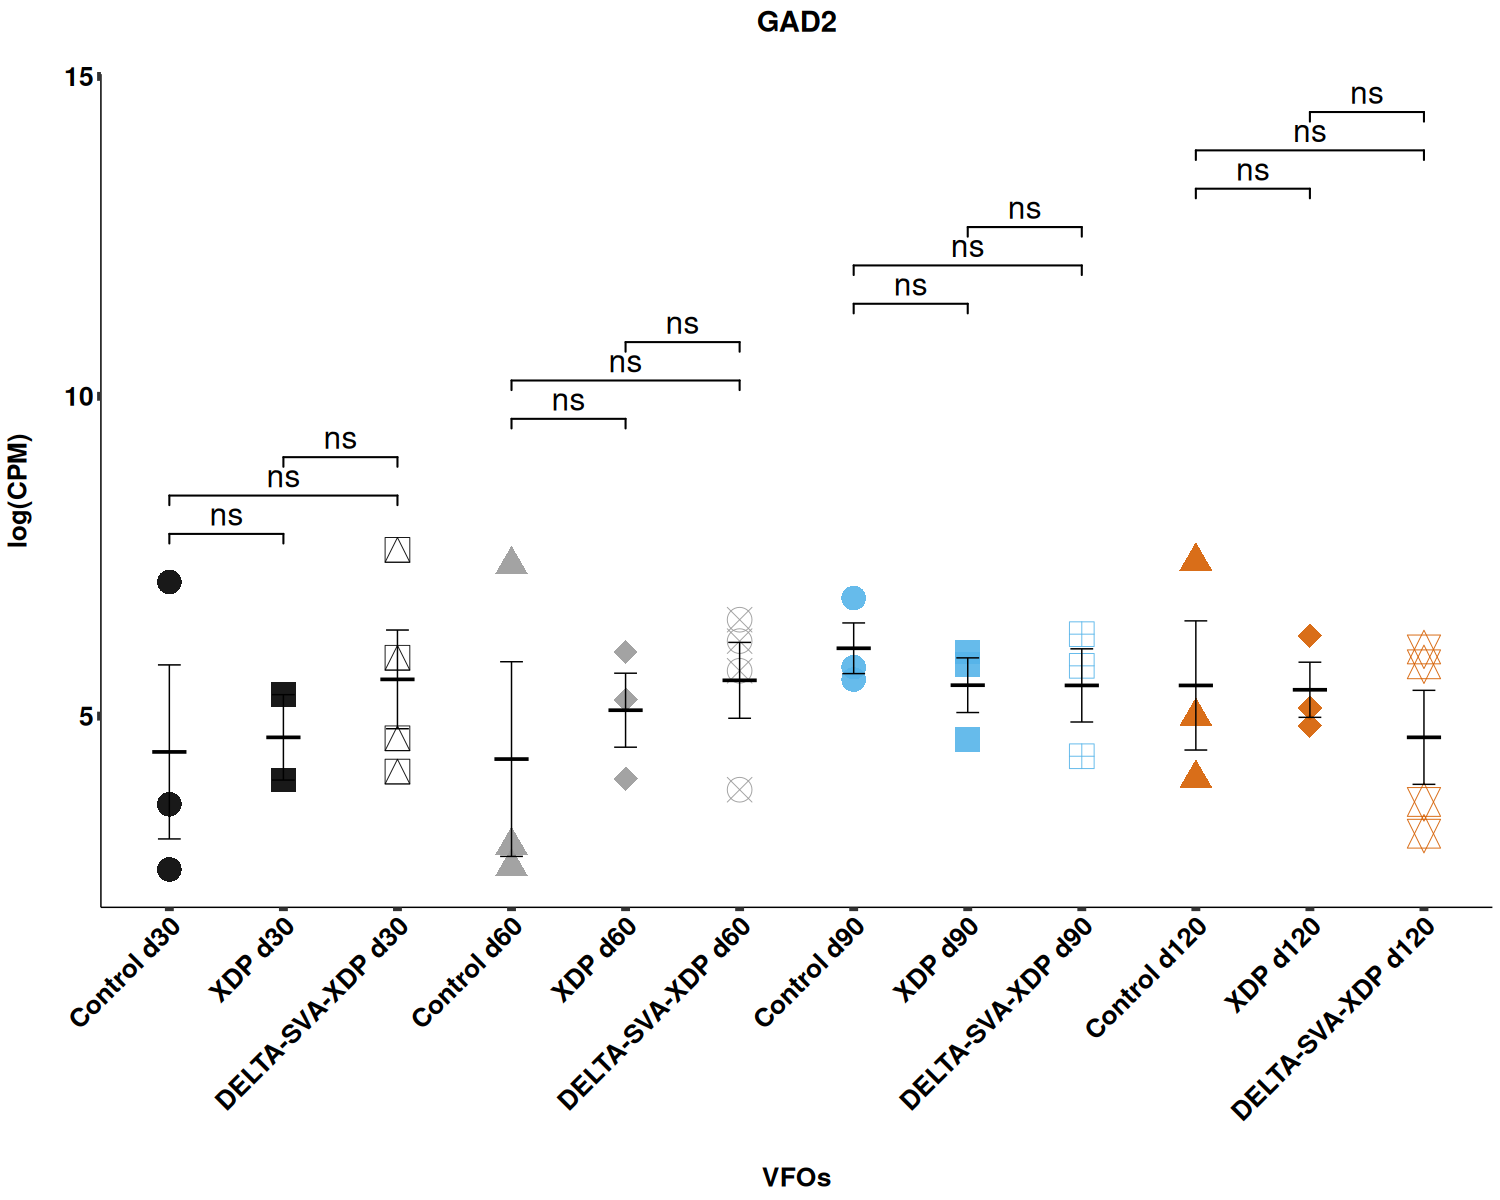

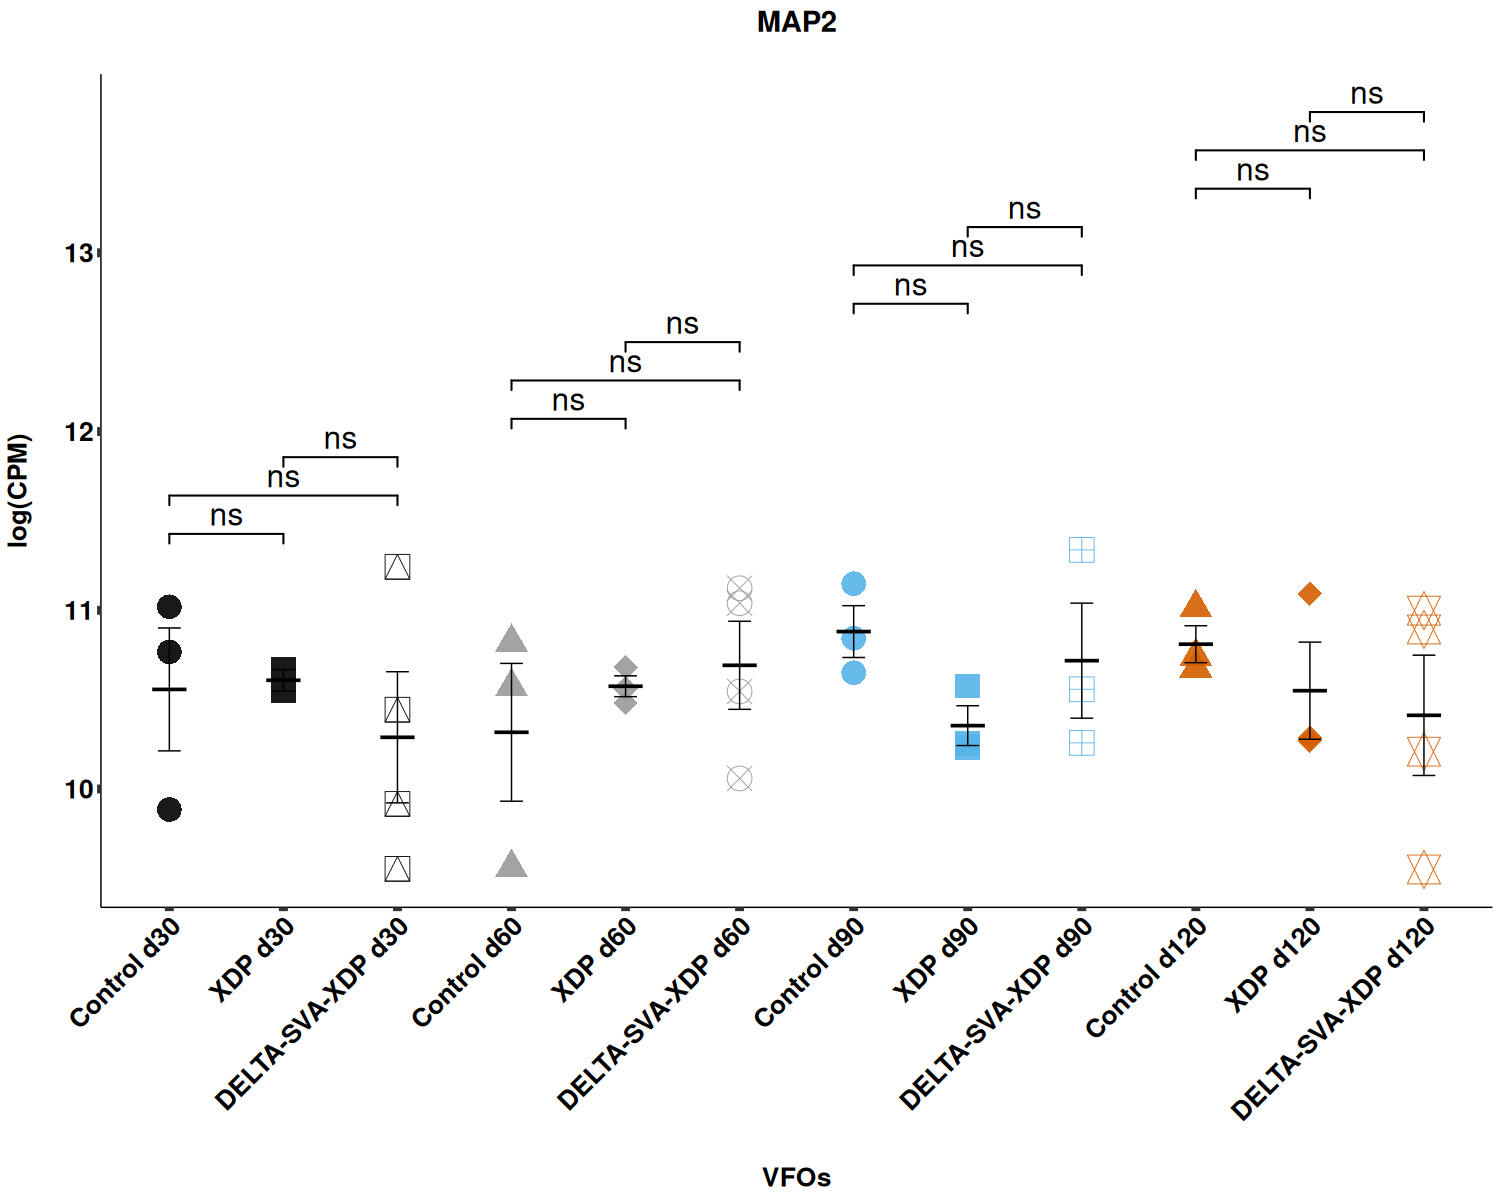

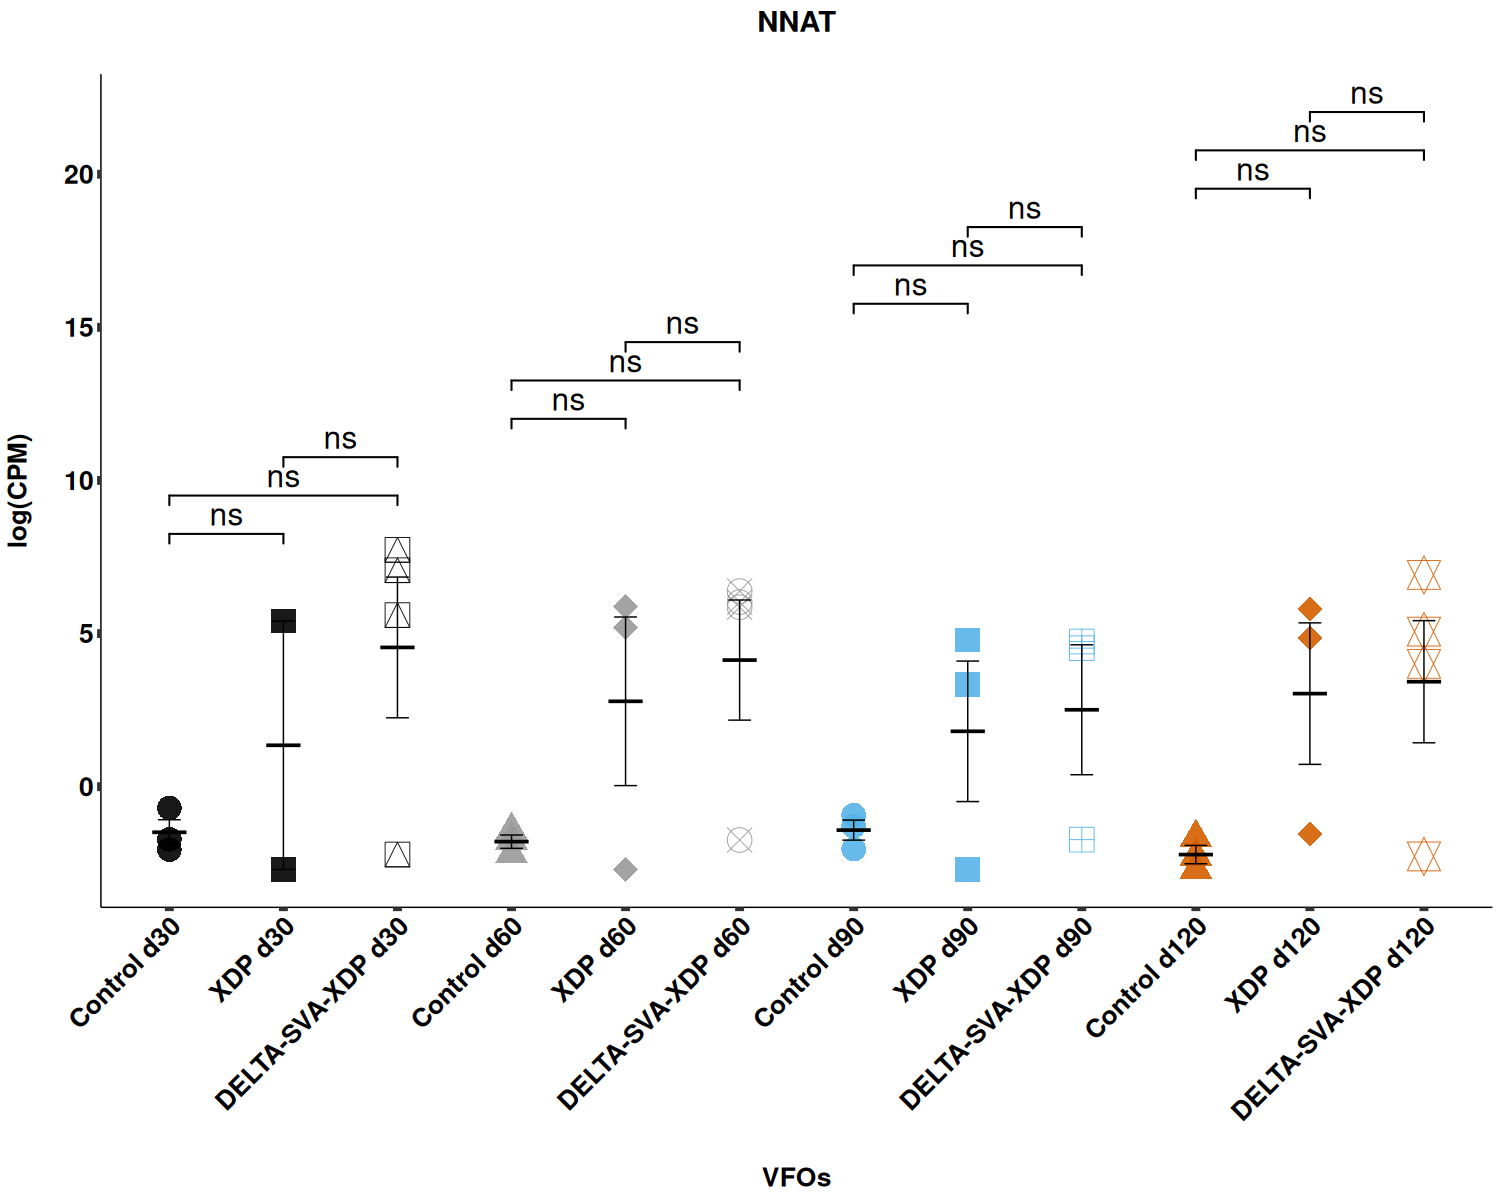

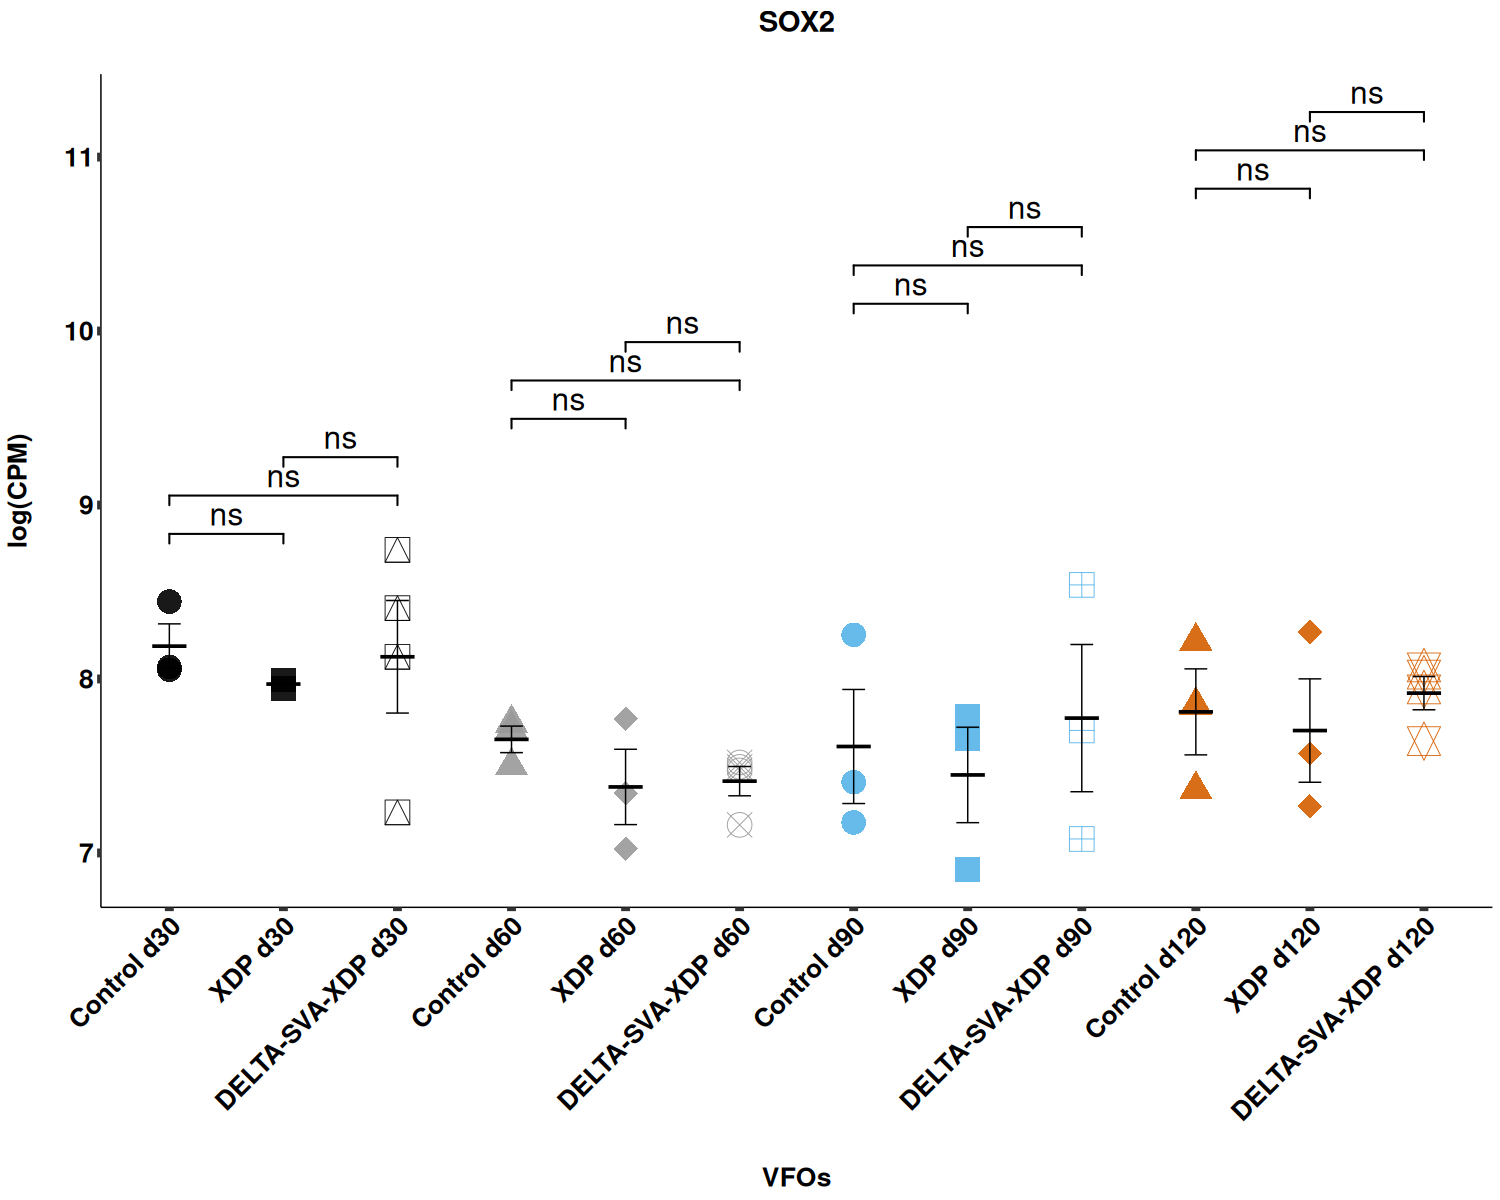

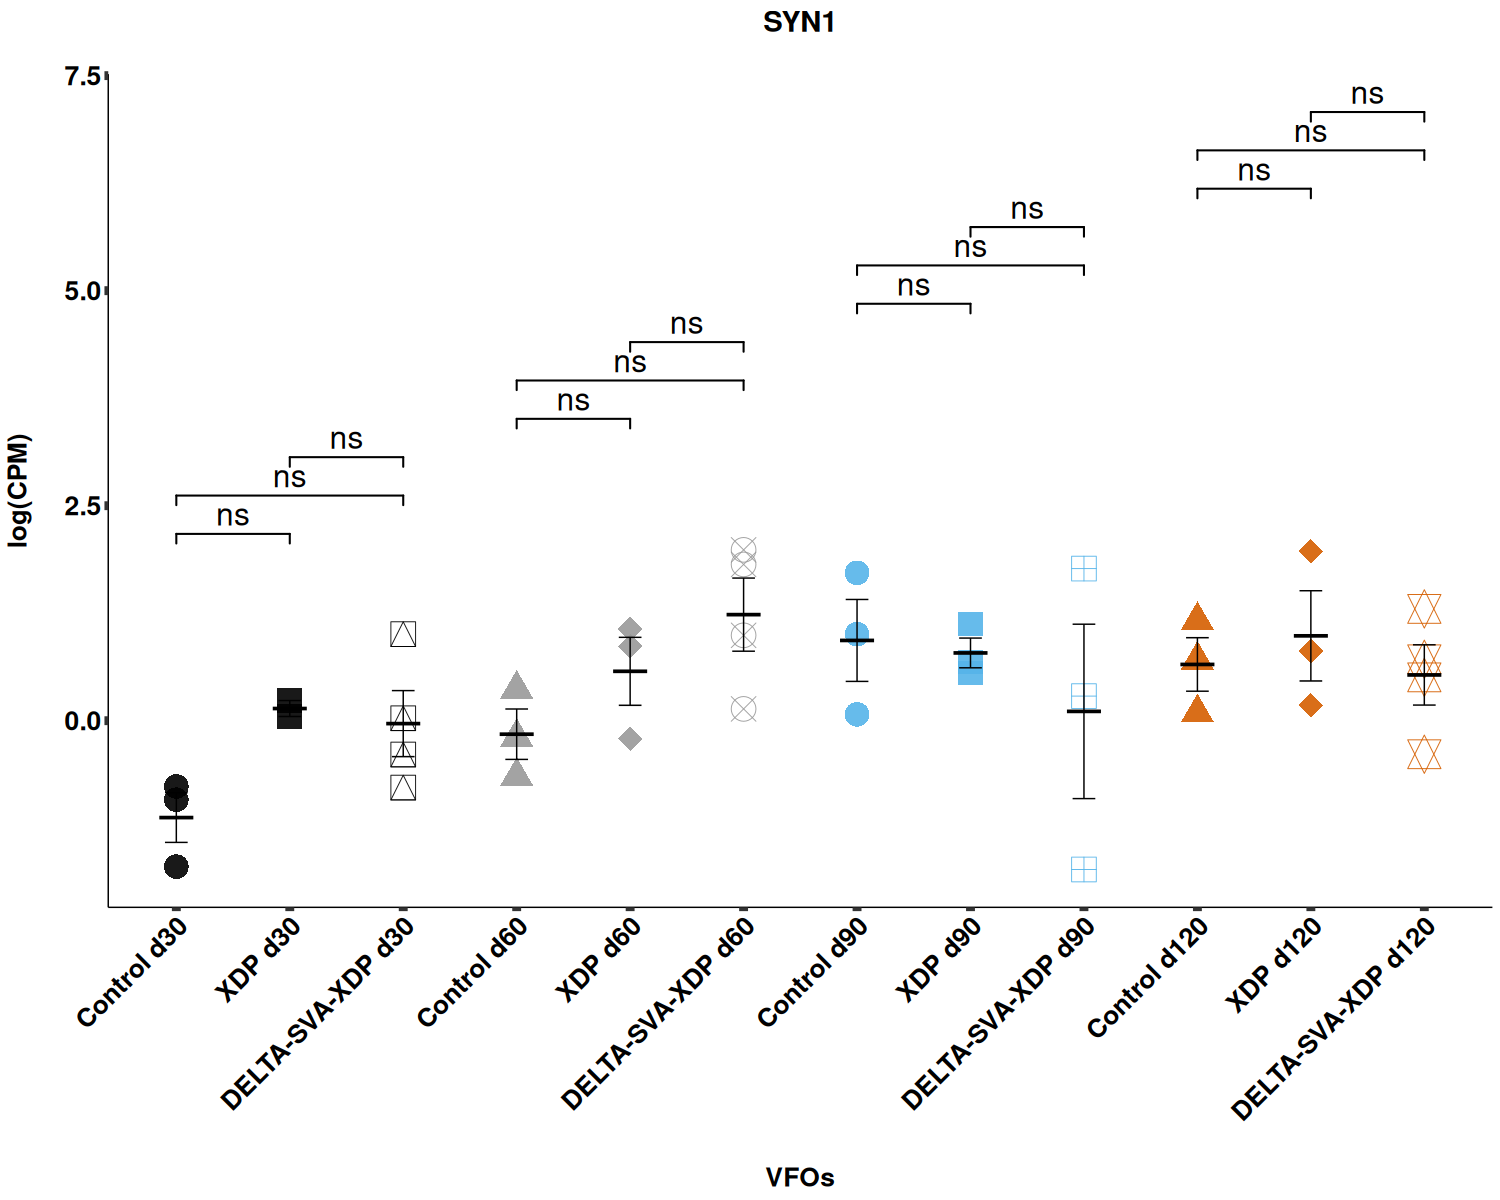

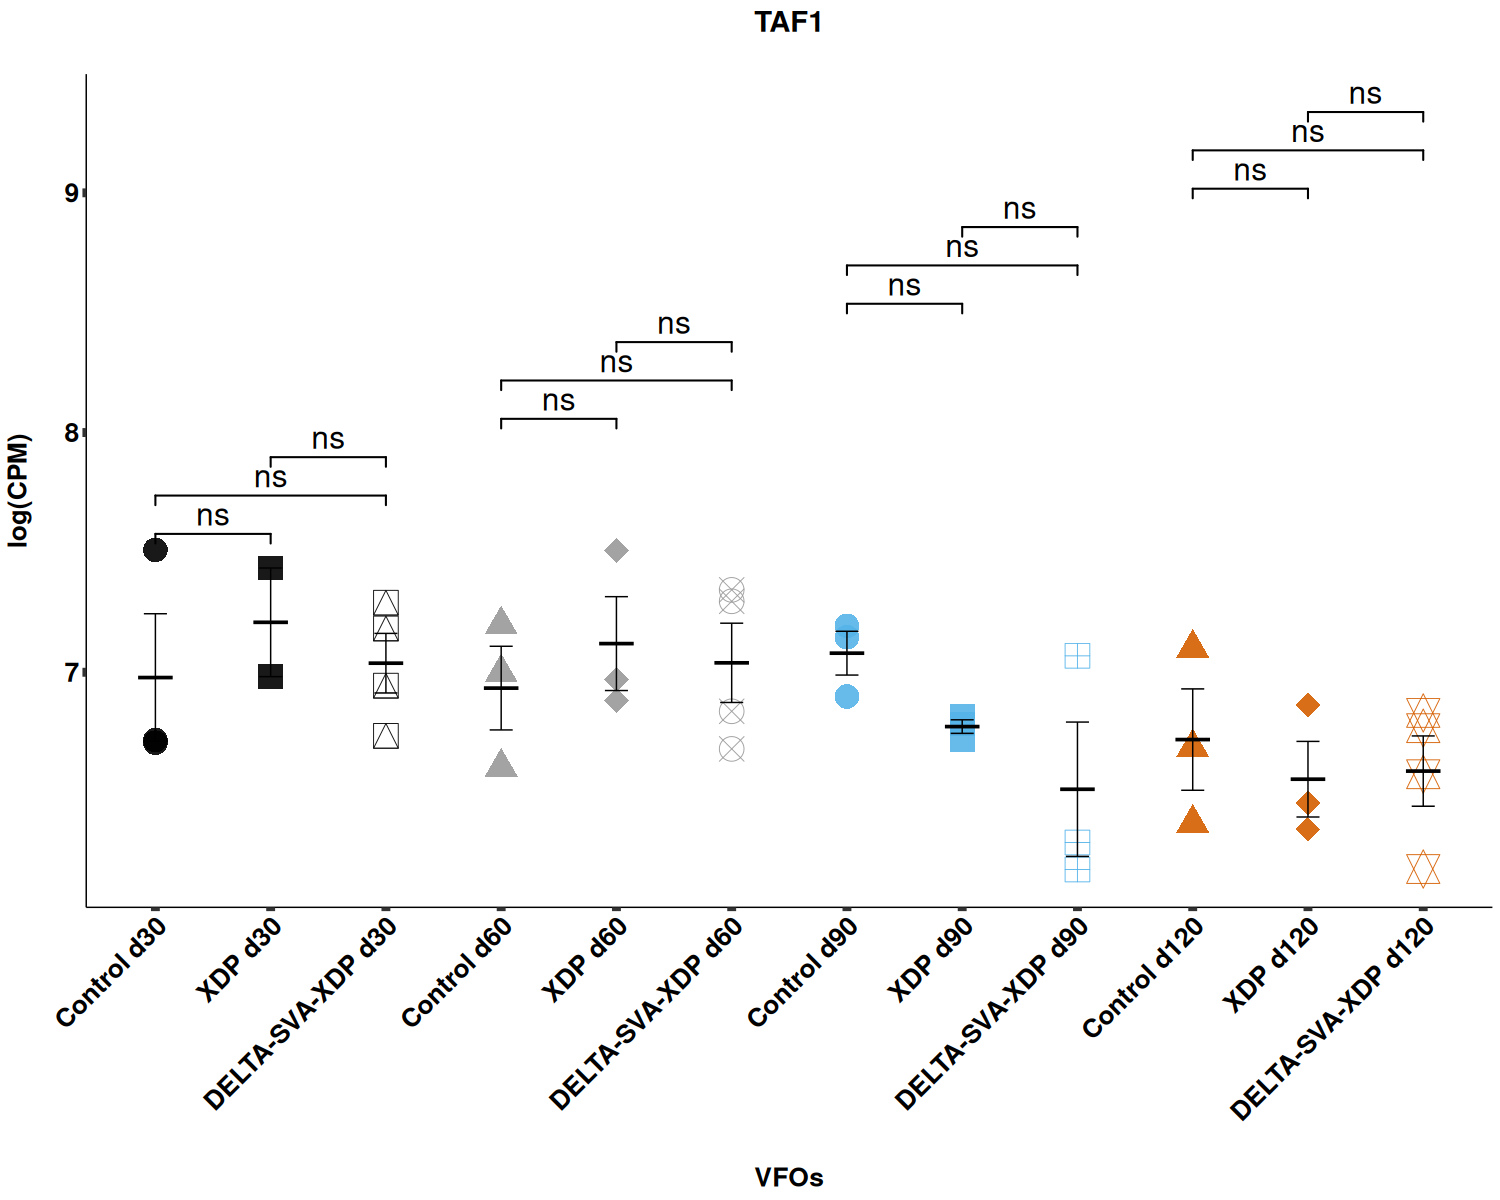

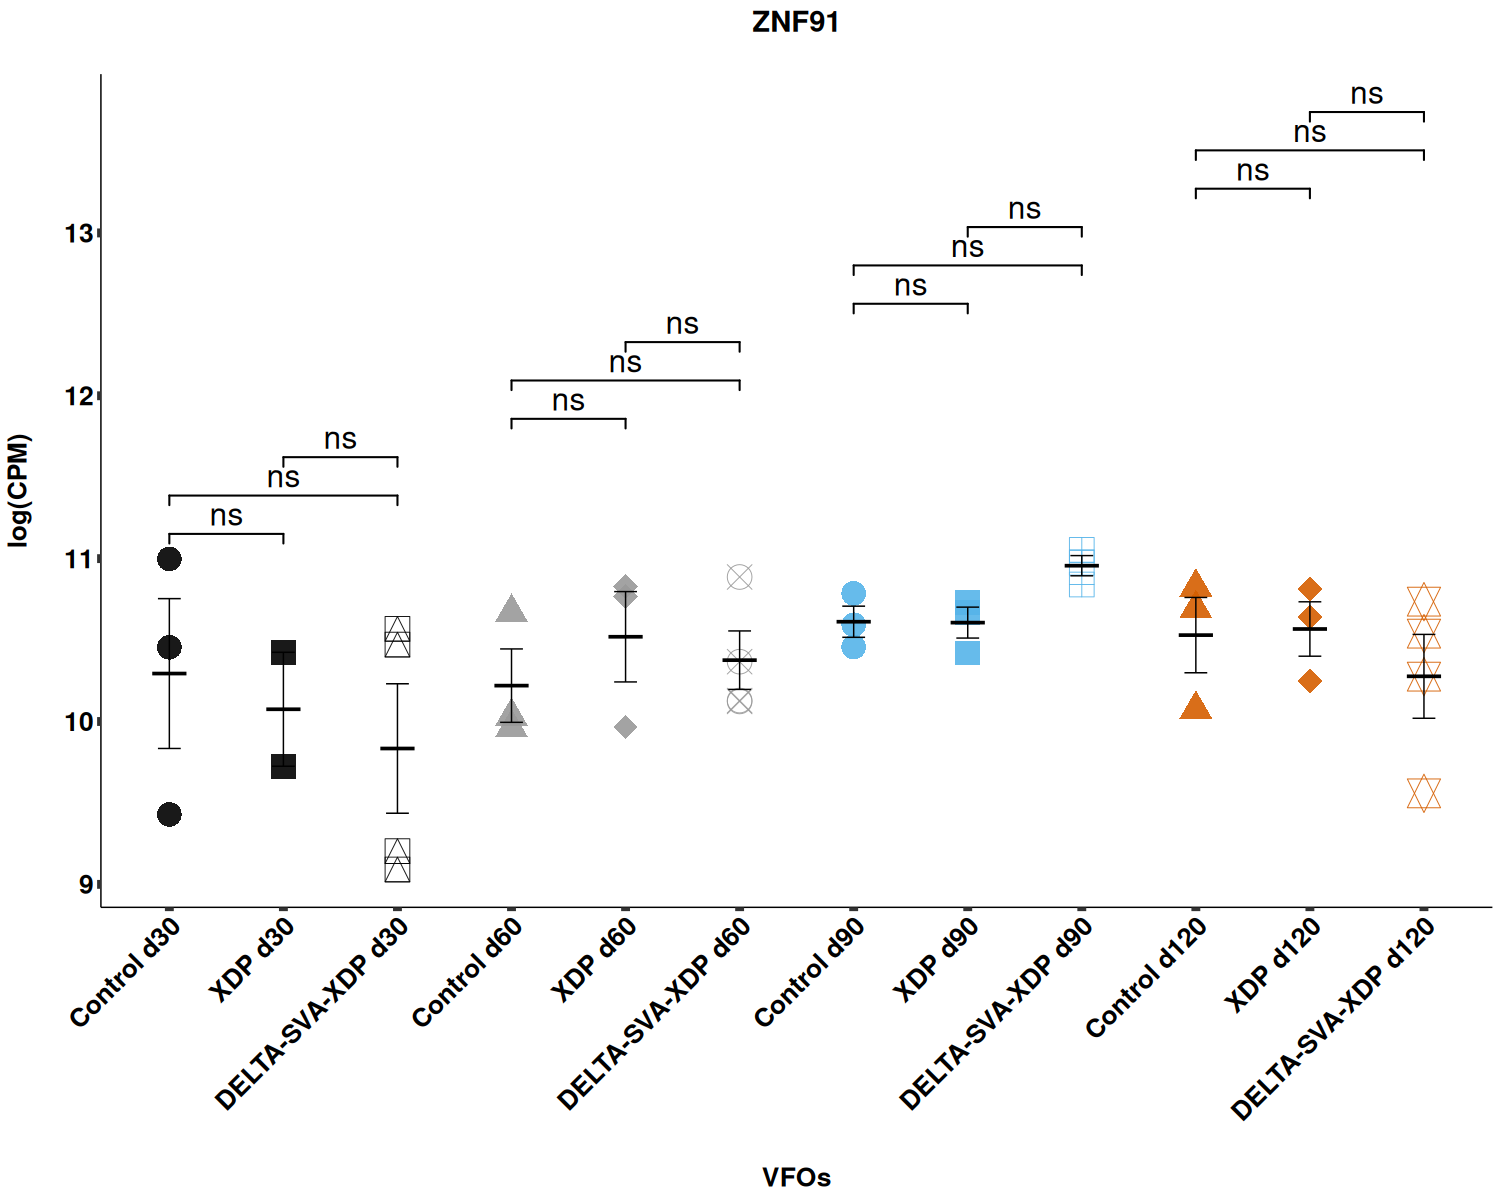

In [31]:
options(repr.plot.width = 15, repr.plot.height = 12, repr.plot.res = 100)



# significant ones: CASP1, MAP2

for (gene in genes_list){



    subset_data <- subset(plot_input, Symbol == gene) #%>% na.omit()
    color_pal <- c("#000000","#000000","#000000",
                   "#999999", "#999999","#999999",  
                   "#56B4E9", "#56B4E9","#56B4E9",
                   "#D55E00", "#D55E00","#D55E00")
    mycomp <- list(c('Control d30', 'XDP d30'), c('Control d30', 'DELTA-SVA-XDP d30'), c('DELTA-SVA-XDP d30', 'XDP d30'),
                   c('Control d60', 'XDP d60'), c('Control d60', 'DELTA-SVA-XDP d60'), c('DELTA-SVA-XDP d60', 'XDP d60'),
                   c('Control d90', 'XDP d90'), c('Control d90', 'DELTA-SVA-XDP d90'), c('DELTA-SVA-XDP d90', 'XDP d90'),
                   c('Control d120', 'XDP d120'), c('Control d120', 'DELTA-SVA-XDP d120'), c('DELTA-SVA-XDP d120', 'XDP d120')
                  ) #change here if necessary
        #'Control d120''XDP d120''Control d30''XDP d30''Control d60''XDP d60''Control d90''XDP d90'

    p1 <- ggplot(subset_data, aes(x = new_labels, y = value, color = new_labels, shape = new_labels)) + 
                geom_point(size = 8, alpha = 0.9) +
                scale_shape_manual(values = c(16, 15, 14, 
                                              17, 18, 13,
                                              16, 15, 12, 
                                              17, 18, 11)) +
                stat_summary(fun.data = mean_cl_normal, 
                             fun.args = list(mult = 1),
                             geom = "errorbar",
                             color = "black",
                             width = 0.2,
                             linetype = "solid"
                             ) +
                stat_summary(fun = "mean",
                             fun.args = list(mult = 1),
                             geom = "crossbar",
                             color = "black",
                             width = 0.3
                             ) +
                scale_color_manual(values = color_pal) +
                labs(title = paste0(gene,'\n'), x = '\nVFOs', y = 'log(CPM)\n') + #change here if necessary
                stat_compare_means(aes(label = ..p.signif..),
                                   size = 8,
                                   comparisons = mycomp,
                                   bracket.size = 0.7,
                                   method = 'wilcox.test') +
                theme_custom +
                guides(color = 'none', shape = 'none') + #remove legend
                theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) # rotate x-axis labels by 45 degrees

    plot(p1)
    save_plot(p = p1,
              fn = paste0(save_path,'all_days_dotplot_',gene),
              w = 15,
              h = 11)
    }

In [32]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Arch Linux

Matrix products: default
BLAS:   /usr/lib/libblas.so.3.12.0 
LAPACK: /usr/lib/liblapack.so.3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: EST
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Hmisc_5.2-1                 edgeR_4.4.1                
 [3] limma_3.62.1                EnhancedVolcano_1.24.0     
 [5] ggrepel_0.9.6               SummarizedExperiment_1.36.0
 [7] Biobase_2.66.0              GenomicRanges_1.58.0       
 [9] GenomeInfoDb_1.42.1